In [18]:
#BASE CLASS FOR SKO

from abc import ABCMeta, abstractmethod
import types
import warnings


class SkoBase(metaclass=ABCMeta):
    def register(self, operator_name, operator, *args, **kwargs):
        '''
        regeister udf to the class
        :param operator_name: string
        :param operator: a function, operator itself
        :param args: arg of operator
        :param kwargs: kwargs of operator
        :return:
        '''

        def operator_wapper(*wrapper_args):
            return operator(*(wrapper_args + args), **kwargs)

        setattr(self, operator_name, types.MethodType(operator_wapper, self))
        return self

    def fit(self, *args, **kwargs):
        warnings.warn('.fit() will be deprecated in the future. use .run() instead.'
                      , DeprecationWarning)
        return self.run(*args, **kwargs)


class Problem(object):
    pass


In [19]:
#tools.py

import numpy as np
from functools import lru_cache
from types import MethodType, FunctionType
import warnings
import sys
import multiprocessing

if sys.platform != 'win32':
    multiprocessing.set_start_method('fork')


def set_run_mode(func, mode):
    '''

    :param func:
    :param mode: string
        can be  common, vectorization , parallel, cached
    :return:
    '''
    if mode == 'multiprocessing' and sys.platform == 'win32':
        warnings.warn('multiprocessing not support in windows, turning to multithreading')
        mode = 'multithreading'
    if mode == 'parallel':
        mode = 'multithreading'
        warnings.warn('use multithreading instead of parallel')
    func.__dict__['mode'] = mode
    return


def func_transformer(func, n_processes):
    '''
    transform this kind of function:
    ```
    def demo_func(x):
        x1, x2, x3 = x
        return x1 ** 2 + x2 ** 2 + x3 ** 2
    ```
    into this kind of function:
    ```
    def demo_func(x):
        x1, x2, x3 = x[:,0], x[:,1], x[:,2]
        return x1 ** 2 + (x2 - 0.05) ** 2 + x3 ** 2
    ```
    getting vectorial performance if possible:
    ```
    def demo_func(x):
        x1, x2, x3 = x[:, 0], x[:, 1], x[:, 2]
        return x1 ** 2 + (x2 - 0.05) ** 2 + x3 ** 2
    ```
    :param func:
    :return:
    '''

    # to support the former version
    if (func.__class__ is FunctionType) and (func.__code__.co_argcount > 1):
        warnings.warn('multi-input might be deprecated in the future, use fun(p) instead')

        def func_transformed(X):
            return np.array([func(*tuple(x)) for x in X])

        return func_transformed

    # to support the former version
    if (func.__class__ is MethodType) and (func.__code__.co_argcount > 2):
        warnings.warn('multi-input might be deprecated in the future, use fun(p) instead')

        def func_transformed(X):
            return np.array([func(tuple(x)) for x in X])

        return func_transformed

    # to support the former version
    if getattr(func, 'is_vector', False):
        warnings.warn('''
        func.is_vector will be deprecated in the future, use set_run_mode(func, 'vectorization') instead
        ''')
        set_run_mode(func, 'vectorization')

    mode = getattr(func, 'mode', 'others')
    valid_mode = ('common', 'multithreading', 'multiprocessing', 'vectorization', 'cached', 'others')
    assert mode in valid_mode, 'valid mode should be in ' + str(valid_mode)
    if mode == 'vectorization':
        return func
    elif mode == 'cached':
        @lru_cache(maxsize=None)
        def func_cached(x):
            return func(x)

        def func_warped(X):
            return np.array([func_cached(tuple(x)) for x in X])

        return func_warped
    elif mode == 'multithreading':
        assert n_processes >= 0, 'n_processes should >= 0'
        from multiprocessing.dummy import Pool as ThreadPool
        if n_processes == 0:
            pool = ThreadPool()
        else:
            pool = ThreadPool(n_processes)

        def func_transformed(X):
            return np.array(pool.map(func, X))

        return func_transformed
    elif mode == 'multiprocessing':
        assert n_processes >= 0, 'n_processes should >= 0'
        from multiprocessing import Pool
        if n_processes == 0:
            pool = Pool()
        else:
            pool = Pool(n_processes)
        def func_transformed(X):
            return np.array(pool.map(func, X))

        return func_transformed

    else:  # common
        def func_transformed(X):
            return np.array([func(x) for x in X])

        return func_transformed


In [20]:
#INITIALIZATION

__version__ = '0.6.6'

# from . import DE, GA, PSO, SA, ACA, AFSA, IA, tools


def start():
    print('''
    scikit-opt import successfully,
    version: {version}
    Author: Guo Fei,
    Email: guofei9987@foxmail.com
    repo: https://github.com/guofei9987/scikit-opt,
    documents: https://scikit-opt.github.io/
    '''.format(version=__version__))


In [21]:
#CROSSOVER

import numpy as np

__all__ = ['crossover_1point', 'crossover_2point', 'crossover_2point_bit', 'crossover_pmx', 'crossover_2point_prob']


def crossover_1point(self):
    Chrom, size_pop, len_chrom = self.Chrom, self.size_pop, self.len_chrom
    for i in range(0, size_pop, 2):
        n = np.random.randint(0, self.len_chrom)
        # crossover at the point n
        seg1, seg2 = self.Chrom[i, n:].copy(), self.Chrom[i + 1, n:].copy()
        self.Chrom[i, n:], self.Chrom[i + 1, n:] = seg2, seg1
    return self.Chrom


def crossover_2point(self):
    Chrom, size_pop, len_chrom = self.Chrom, self.size_pop, self.len_chrom
    for i in range(0, size_pop, 2):
        n1, n2 = np.random.randint(0, self.len_chrom, 2)
        if n1 > n2:
            n1, n2 = n2, n1
        # crossover at the points n1 to n2
        seg1, seg2 = self.Chrom[i, n1:n2].copy(), self.Chrom[i + 1, n1:n2].copy()
        self.Chrom[i, n1:n2], self.Chrom[i + 1, n1:n2] = seg2, seg1
    return self.Chrom


def crossover_2point_bit(self):
    '''
    3 times faster than `crossover_2point`, but only use for 0/1 type of Chrom
    :param self:
    :return:
    '''
    Chrom, size_pop, len_chrom = self.Chrom, self.size_pop, self.len_chrom
    half_size_pop = int(size_pop / 2)
    Chrom1, Chrom2 = Chrom[:half_size_pop], Chrom[half_size_pop:]
    mask = np.zeros(shape=(half_size_pop, len_chrom), dtype=int)
    for i in range(half_size_pop):
        n1, n2 = np.random.randint(0, self.len_chrom, 2)
        if n1 > n2:
            n1, n2 = n2, n1
        mask[i, n1:n2] = 1
    mask2 = (Chrom1 ^ Chrom2) & mask
    Chrom1 ^= mask2
    Chrom2 ^= mask2
    return self.Chrom


def crossover_2point_prob(self, crossover_prob):
    '''
    2 points crossover with probability
    '''
    Chrom, size_pop, len_chrom = self.Chrom, self.size_pop, self.len_chrom
    for i in range(0, size_pop, 2):
        if np.random.rand() < crossover_prob:
            n1, n2 = np.random.randint(0, self.len_chrom, 2)
            if n1 > n2:
                n1, n2 = n2, n1
            seg1, seg2 = self.Chrom[i, n1:n2].copy(), self.Chrom[i + 1, n1:n2].copy()
            self.Chrom[i, n1:n2], self.Chrom[i + 1, n1:n2] = seg2, seg1
    return self.Chrom


# def crossover_rv_3(self):
#     Chrom, size_pop = self.Chrom, self.size_pop
#     i = np.random.randint(1, self.len_chrom)  # crossover at the point i
#     Chrom1 = np.concatenate([Chrom[::2, :i], Chrom[1::2, i:]], axis=1)
#     Chrom2 = np.concatenate([Chrom[1::2, :i], Chrom[0::2, i:]], axis=1)
#     self.Chrom = np.concatenate([Chrom1, Chrom2], axis=0)
#     return self.Chrom


def crossover_pmx(self):
    '''
    Executes a partially matched crossover (PMX) on Chrom.
    For more details see [Goldberg1985]_.

    :param self:
    :return:

    .. [Goldberg1985] Goldberg and Lingel, "Alleles, loci, and the traveling
   salesman problem", 1985.
    '''
    Chrom, size_pop, len_chrom = self.Chrom, self.size_pop, self.len_chrom
    for i in range(0, size_pop, 2):
        Chrom1, Chrom2 = self.Chrom[i], self.Chrom[i + 1]
        cxpoint1, cxpoint2 = np.random.randint(0, self.len_chrom - 1, 2)
        if cxpoint1 >= cxpoint2:
            cxpoint1, cxpoint2 = cxpoint2, cxpoint1 + 1
        # crossover at the point cxpoint1 to cxpoint2
        pos1_recorder = {value: idx for idx, value in enumerate(Chrom1)}
        pos2_recorder = {value: idx for idx, value in enumerate(Chrom2)}
        for j in range(cxpoint1, cxpoint2):
            value1, value2 = Chrom1[j], Chrom2[j]
            pos1, pos2 = pos1_recorder[value2], pos2_recorder[value1]
            Chrom1[j], Chrom1[pos1] = Chrom1[pos1], Chrom1[j]
            Chrom2[j], Chrom2[pos2] = Chrom2[pos2], Chrom2[j]
            pos1_recorder[value1], pos1_recorder[value2] = pos1, j
            pos2_recorder[value1], pos2_recorder[value2] = j, pos2

        self.Chrom[i], self.Chrom[i + 1] = Chrom1, Chrom2
    return self.Chrom


In [22]:
#MUTATION

import numpy as np


def mutation(self):
    '''
    mutation of 0/1 type chromosome
    faster than `self.Chrom = (mask + self.Chrom) % 2`
    :param self:
    :return:
    '''
    #
    mask = (np.random.rand(self.size_pop, self.len_chrom) < self.prob_mut)
    self.Chrom ^= mask
    return self.Chrom


def mutation_TSP_1(self):
    '''
    every gene in every chromosome mutate
    :param self:
    :return:
    '''
    for i in range(self.size_pop):
        for j in range(self.n_dim):
            if np.random.rand() < self.prob_mut:
                n = np.random.randint(0, self.len_chrom, 1)
                self.Chrom[i, j], self.Chrom[i, n] = self.Chrom[i, n], self.Chrom[i, j]
    return self.Chrom


def swap(individual):
    n1, n2 = np.random.randint(0, individual.shape[0] - 1, 2)
    if n1 >= n2:
        n1, n2 = n2, n1 + 1
    individual[n1], individual[n2] = individual[n2], individual[n1]
    return individual


def reverse(individual):
    '''
    Reverse n1 to n2
    Also called `2-Opt`: removes two random edges, reconnecting them so they cross
    Karan Bhatia, "Genetic Algorithms and the Traveling Salesman Problem", 1994
    https://pdfs.semanticscholar.org/c5dd/3d8e97202f07f2e337a791c3bf81cd0bbb13.pdf
    '''
    n1, n2 = np.random.randint(0, individual.shape[0] - 1, 2)
    if n1 >= n2:
        n1, n2 = n2, n1 + 1
    individual[n1:n2] = individual[n1:n2][::-1]
    return individual


def transpose(individual):
    # randomly generate n1 < n2 < n3. Notice: not equal
    n1, n2, n3 = sorted(np.random.randint(0, individual.shape[0] - 2, 3))
    n2 += 1
    n3 += 2
    slice1, slice2, slice3, slice4 = individual[0:n1], individual[n1:n2], individual[n2:n3 + 1], individual[n3 + 1:]
    individual = np.concatenate([slice1, slice3, slice2, slice4])
    return individual


def mutation_reverse(self):
    '''
    Reverse
    :param self:
    :return:
    '''
    for i in range(self.size_pop):
        if np.random.rand() < self.prob_mut:
            self.Chrom[i] = reverse(self.Chrom[i])
    return self.Chrom


def mutation_swap(self):
    for i in range(self.size_pop):
        if np.random.rand() < self.prob_mut:
            self.Chrom[i] = swap(self.Chrom[i])
    return self.Chrom


In [23]:
#RANKING

import numpy as np


def ranking(self):
    # GA select the biggest one, but we want to minimize func, so we put a negative here
    self.FitV = -self.Y


def ranking_linear(self):
    '''
    For more details see [Baker1985]_.

    :param self:
    :return:

    .. [Baker1985] Baker J E, "Adaptive selection methods for genetic
    algorithms, 1985.
    '''
    self.FitV = np.argsort(np.argsort(-self.Y))
    return self.FitV


In [24]:
#SELECTION

import numpy as np
def selection_tournament(self, tourn_size=3):
    '''
    Select the best individual among *tournsize* randomly chosen
    individuals,
    :param self:
    :param tourn_size:
    :return:
    '''
    FitV = self.FitV
    sel_index = []
    for i in range(self.size_pop):
        # aspirants_index = np.random.choice(range(self.size_pop), size=tourn_size)
        aspirants_index = np.random.randint(self.size_pop, size=tourn_size)
        sel_index.append(max(aspirants_index, key=lambda i: FitV[i]))
    self.Chrom = self.Chrom[sel_index, :]  # next generation
    return self.Chrom


def selection_tournament_faster(self, tourn_size=3):
    '''
    Select the best individual among *tournsize* randomly chosen
    Same with `selection_tournament` but much faster using numpy
    individuals,
    :param self:
    :param tourn_size:
    :return:
    '''
    aspirants_idx = np.random.randint(self.size_pop, size=(self.size_pop, tourn_size))
    aspirants_values = self.FitV[aspirants_idx]
    winner = aspirants_values.argmax(axis=1)  # winner index in every team
    sel_index = [aspirants_idx[i, j] for i, j in enumerate(winner)]
    self.Chrom = self.Chrom[sel_index, :]
    return self.Chrom


def selection_roulette_1(self):
    '''
    Select the next generation using roulette
    :param self:
    :return:
    '''
    FitV = self.FitV
    FitV = FitV - FitV.min() + 1e-10
    # the worst one should still has a chance to be selected
    sel_prob = FitV / FitV.sum()
    sel_index = np.random.choice(range(self.size_pop), size=self.size_pop, p=sel_prob)
    self.Chrom = self.Chrom[sel_index, :]
    return self.Chrom


def selection_roulette_2(self):
    '''
    Select the next generation using roulette
    :param self:
    :return:
    '''
    FitV = self.FitV
    FitV = (FitV - FitV.min()) / (FitV.max() - FitV.min() + 1e-10) + 0.2
    # the worst one should still has a chance to be selected
    sel_prob = FitV / FitV.sum()
    sel_index = np.random.choice(range(self.size_pop), size=self.size_pop, p=sel_prob)
    self.Chrom = self.Chrom[sel_index, :]
    return self.Chrom



In [25]:
# Object Function

import numpy as np
from sko.GA import GA
import pandas as pd
import matplotlib.pyplot as plt

def rosenbrock(p):
    '''
    Rosenbrock function for n-dimensional input.
    Global minimum at (1, 1, ..., 1) with value 0.
    '''
    return sum(100.0 * (p[1:] - p[:-1]**2.0)**2.0 + (1 - p[:-1])**2.0)

def rastrigin(p):
    '''
    Rastrigin function for n-dimensional input.
    Global minimum at (0, 0, ..., 0) with value 0.
    '''
    return 10 * len(p) + sum([x**2 - 10 * np.cos(2 * np.pi * x) for x in p])

def griewank(p):
    '''
    Griewank function for n-dimensional input.
    Global minimum at (0, 0, ..., 0) with value 0.
    '''
    part1 = sum([x**2 for x in p]) / 4000
    part2 = np.prod([np.cos(x / np.sqrt(i + 1)) for i, x in enumerate(p)])
    return 1 + part1 - part2

In [26]:
#GA

from sko.operators import ranking, selection

# import sys
#     sys.path.append('C:\Users\songy\Desktop\KU\optimization\scikit-opt')

from sko.operators import ranking
import numpy as np
from sko.base import SkoBase
from sko.tools import func_transformer
from abc import ABCMeta, abstractmethod
from sko.operators import crossover, mutation, ranking, selection


class GeneticAlgorithmBase(SkoBase, metaclass=ABCMeta):
    def __init__(self, func, n_dim,
                 size_pop=50, max_iter=200, prob_mut=0.001,
                 constraint_eq=tuple(), constraint_ueq=tuple(), early_stop=None, n_processes=0):
        self.func = func_transformer(func, n_processes)
        assert size_pop % 2 == 0, 'size_pop must be even integer'
        self.size_pop = size_pop  # size of population
        self.max_iter = max_iter
        self.prob_mut = prob_mut  # probability of mutation
        self.n_dim = n_dim
        self.early_stop = early_stop

        # constraint:
        self.has_constraint = len(constraint_eq) > 0 or len(constraint_ueq) > 0
        self.constraint_eq = list(constraint_eq)  # a list of equal functions with ceq[i] = 0
        self.constraint_ueq = list(constraint_ueq)  # a list of unequal constraint functions with c[i] <= 0

        self.Chrom = None
        self.X = None  # shape = (size_pop, n_dim)
        self.Y_raw = None  # shape = (size_pop,) , value is f(x)
        self.Y = None  # shape = (size_pop,) , value is f(x) + penalty for constraint
        self.FitV = None  # shape = (size_pop,)

        # self.FitV_history = []
        self.generation_best_X = []
        self.generation_best_Y = []

        self.all_history_Y = []
        self.all_history_FitV = []

        self.best_x, self.best_y = None, None

    @abstractmethod
    def chrom2x(self, Chrom):
        pass

    def x2y(self):
        self.Y_raw = self.func(self.X)
        if not self.has_constraint:
            self.Y = self.Y_raw
        else:
            # constraint
            penalty_eq = np.array([np.sum(np.abs([c_i(x) for c_i in self.constraint_eq])) for x in self.X])
            penalty_ueq = np.array([np.sum(np.abs([max(0, c_i(x)) for c_i in self.constraint_ueq])) for x in self.X])
            self.Y = self.Y_raw + 1e5 * penalty_eq + 1e5 * penalty_ueq
        return self.Y

    @abstractmethod
    def ranking(self):
        ranking(self)
        pass

    @abstractmethod
    def selection(self):
        pass

    @abstractmethod
    def crossover(self):
        crossover_2point = crossover_2point
        pass

    @abstractmethod
    def mutation(self):
        mutation_TSP_1 = mutation_TSP_1
        pass

    def run(self, max_iter=None):
        self.max_iter = max_iter or self.max_iter
        best = []
        for i in range(self.max_iter):
            self.X = self.chrom2x(self.Chrom)
            self.Y = self.x2y()
            self.ranking()
            self.selection()
            self.crossover()
            self.mutation()

            # record the best ones
            generation_best_index = self.FitV.argmax()
            self.generation_best_X.append(self.X[generation_best_index, :])
            self.generation_best_Y.append(self.Y[generation_best_index])
            self.all_history_Y.append(self.Y)
            self.all_history_FitV.append(self.FitV)

            if self.early_stop:
                best.append(min(self.generation_best_Y))
                if len(best) >= self.early_stop:
                    if best.count(min(best)) == len(best):
                        break
                    else:
                        best.pop(0)

        global_best_index = np.array(self.generation_best_Y).argmin()
        self.best_x = self.generation_best_X[global_best_index]
        self.best_y = self.func(np.array([self.best_x]))
        return self.best_x, self.best_y

    fit = run


class GA(GeneticAlgorithmBase):
    """genetic algorithm

    Parameters
    ----------------
    func : function
        The func you want to do optimal
    n_dim : int
        number of variables of func
    lb : array_like
        The lower bound of every variables of func
    ub : array_like
        The upper bound of every variables of func
    constraint_eq : tuple
        equal constraint
    constraint_ueq : tuple
        unequal constraint
    precision : array_like
        The precision of every variables of func
    size_pop : int
        Size of population
    max_iter : int
        Max of iter
    prob_mut : float between 0 and 1
        Probability of mutation
    n_processes : int
        Number of processes, 0 means use all cpu
    Attributes
    ----------------------
    Lind : array_like
         The num of genes of every variable of func（segments）
    generation_best_X : array_like. Size is max_iter.
        Best X of every generation
    generation_best_ranking : array_like. Size if max_iter.
        Best ranking of every generation
    Examples
    -------------
    https://github.com/guofei9987/scikit-opt/blob/master/examples/demo_ga.py
    """

    def __init__(self, func, n_dim,
                 size_pop=50, max_iter=200,
                 prob_mut=0.001,
                 lb=-1, ub=1,
                 constraint_eq=tuple(), constraint_ueq=tuple(),
                 precision=1e-7, early_stop=None, n_processes=0):
        super().__init__(func, n_dim, size_pop, max_iter, prob_mut, constraint_eq, constraint_ueq, early_stop, n_processes=n_processes)

        self.lb, self.ub = np.array(lb) * np.ones(self.n_dim), np.array(ub) * np.ones(self.n_dim)
        self.precision = np.array(precision) * np.ones(self.n_dim)  # works when precision is int, float, list or array

        # Lind is the num of genes of every variable of func（segments）
        Lind_raw = np.log2((self.ub - self.lb) / self.precision + 1)
        self.Lind = np.ceil(Lind_raw).astype(int)

        # if precision is integer:
        # if Lind_raw is integer, which means the number of all possible value is 2**n, no need to modify
        # if Lind_raw is decimal, we need ub_extend to make the number equal to 2**n,
        self.int_mode_ = (self.precision % 1 == 0) & (Lind_raw % 1 != 0)
        self.int_mode = np.any(self.int_mode_)
        if self.int_mode:
            self.ub_extend = np.where(self.int_mode_
                                      , self.lb + (np.exp2(self.Lind) - 1) * self.precision
                                      , self.ub)

        self.len_chrom = sum(self.Lind)

        self.crtbp()

    def crtbp(self):
        # create the population
        self.Chrom = np.random.randint(low=0, high=2, size=(self.size_pop, self.len_chrom))
        return self.Chrom

    def gray2rv(self, gray_code):
        # Gray Code to real value: one piece of a whole chromosome
        # input is a 2-dimensional numpy array of 0 and 1.
        # output is a 1-dimensional numpy array which convert every row of input into a real number.
        _, len_gray_code = gray_code.shape
        b = gray_code.cumsum(axis=1) % 2
        mask = np.logspace(start=1, stop=len_gray_code, base=0.5, num=len_gray_code)
        return (b * mask).sum(axis=1) / mask.sum()

    def chrom2x(self, Chrom):
        cumsum_len_segment = self.Lind.cumsum()
        X = np.zeros(shape=(self.size_pop, self.n_dim))
        for i, j in enumerate(cumsum_len_segment):
            if i == 0:
                Chrom_temp = Chrom[:, :cumsum_len_segment[0]]
            else:
                Chrom_temp = Chrom[:, cumsum_len_segment[i - 1]:cumsum_len_segment[i]]
            X[:, i] = self.gray2rv(Chrom_temp)

        if self.int_mode:
            X = self.lb + (self.ub_extend - self.lb) * X
            X = np.where(X > self.ub, self.ub, X)
            # the ub may not obey precision, which is ok.
            # for example, if precision=2, lb=0, ub=5, then x can be 5
        else:
            X = self.lb + (self.ub - self.lb) * X
        return X

    ranking = ranking
    selection = selection.selection_tournament_faster
    crossover = crossover
    mutation = mutation.mutation_TSP_1

class EGA(GA):
    """

    """
    def __init__(self, func, n_dim,
                 size_pop=50, max_iter=200,
                 prob_mut=0.001, n_elitist=0,
                 lb=-1, ub=1,
                 constraint_eq=tuple(), constraint_ueq=tuple(),
                 precision=1e-7, early_stop=None):
        super().__init__(func, n_dim, size_pop, max_iter, prob_mut, lb, ub, constraint_eq, constraint_ueq, precision,
                         early_stop)
        self._n_elitist = n_elitist

    def run(self, max_iter=None):
        self.max_iter = max_iter or self.max_iter
        best = []
        for i in range(self.max_iter):
            self.X = self.chrom2x(self.Chrom)
            self.Y = self.x2y()
            self.ranking()

            # select elitists do not selection(), crossover() and mutation() and remove them from population
            # provisionally.
            idx_elitist = np.sort(self.Y.argsort()[0:self._n_elitist])
            self.size_pop -= self._n_elitist
            elitist_FitV = np.take(self.FitV, idx_elitist, axis=0)
            self.FitV = np.delete(self.FitV, idx_elitist, axis=0)
            elitist_Chrom = np.take(self.Chrom, idx_elitist, axis=0)
            self.Chrom = np.delete(self.Chrom, idx_elitist, axis=0)

            self.selection()
            self.crossover()
            self.mutation()

            # add elitists back to next generation population.
            idx_insert = np.array([idx_v - i for i, idx_v in enumerate(idx_elitist)])
            self.size_pop += self._n_elitist
            self.FitV = np.insert(self.FitV, idx_insert, elitist_FitV, axis=0)
            self.Chrom = np.insert(self.Chrom, idx_insert, elitist_Chrom, axis=0)

            # record the best ones
            generation_best_index = self.FitV.argmax()
            self.generation_best_X.append(self.X[generation_best_index, :])
            self.generation_best_Y.append(self.Y[generation_best_index])
            self.all_history_Y.append(self.Y)
            self.all_history_FitV.append(self.FitV)

            if self.early_stop:
                best.append(min(self.generation_best_Y))
                if len(best) >= self.early_stop:
                    if best.count(min(best)) == len(best):
                        break
                    else:
                        best.pop(0)

        global_best_index = np.array(self.generation_best_Y).argmin()
        self.best_x = self.generation_best_X[global_best_index]
        self.best_y = self.func(np.array([self.best_x]))
        return self.best_x, self.best_y


class RCGA(GeneticAlgorithmBase):
    """real-coding genetic algorithm

    Parameters
    ----------------
    func : function
        The func you want to do optimal
    n_dim : int
        number of variables of func
    size_pop : int
        Size of population
    max_iter : int
        Max of iter
    prob_mut : float between 0 and 1
        Probability of mutation
    prob_cros : float between 0 and 1
        Probability of crossover
    lb : array_like
        The lower bound of every variables of func
    ub : array_like
        The upper bound of every variables of func
    n_processes : int
        Number of processes, 0 means use all cpu
    """

    def __init__(self, func, n_dim,
                 size_pop=50, max_iter=200,
                 prob_mut=0.001,
                 prob_cros=0.9,
                 lb=-1, ub=1,
                 n_processes=0
                 ):
        super().__init__(func, n_dim, size_pop, max_iter, prob_mut, n_processes=n_processes)
        self.lb, self.ub = np.array(lb) * np.ones(self.n_dim), np.array(ub) * np.ones(self.n_dim)
        self.prob_cros = prob_cros
        self.crtbp()

    def crtbp(self):
        # create the population, random floating point numbers of 0 ~ 1
        self.Chrom = np.random.random([self.size_pop, self.n_dim])
        return self.Chrom

    def chrom2x(self, Chrom):
        X = self.lb + (self.ub - self.lb) * self.Chrom
        return X

    def crossover_SBX(self):
        '''
        simulated binary crossover
        :param self:
        :return self.Chrom:
        '''
        Chrom, size_pop, len_chrom, Y = self.Chrom, self.size_pop, len(self.Chrom[0]), self.FitV
        for i in range(0, size_pop, 2):

            if np.random.random() > self.prob_cros:
                continue
            for j in range(len_chrom):

                ylow = 0
                yup = 1
                y1 = Chrom[i][j]
                y2 = Chrom[i + 1][j]
                r = np.random.random()
                if r <= 0.5:
                    betaq = (2 * r) ** (1.0 / (1 + 1.0))
                else:
                    betaq = (0.5 / (1.0 - r)) ** (1.0 / (1 + 1.0))

                child1 = 0.5 * ((1 + betaq) * y1 + (1 - betaq) * y2)
                child2 = 0.5 * ((1 - betaq) * y1 + (1 + betaq) * y2)

                child1 = min(max(child1, ylow), yup)
                child2 = min(max(child2, ylow), yup)

                self.Chrom[i][j] = child1
                self.Chrom[i + 1][j] = child2
        return self.Chrom

    def mutation(self):
        '''
        Routine for real polynomial mutation of an individual
        mutation of 0/1 type chromosome
        :param self:
        :return:
        '''
        #
        size_pop, n_dim, Chrom = self.size_pop, self.n_dim, self.Chrom
        for i in range(size_pop):
            for j in range(n_dim):
                r = np.random.random()
                if r <= self.prob_mut:
                    y = Chrom[i][j]
                    ylow = 0
                    yup = 1
                    delta1 = 1.0 * (y - ylow) / (yup - ylow)
                    delta2 = 1.0 * (yup - y) / (yup - ylow)
                    r = np.random.random()
                    mut_pow = 1.0 / (1 + 1.0)
                    if r <= 0.5:
                        xy = 1.0 - delta1
                        val = 2.0 * r + (1.0 - 2.0 * r) * (xy ** (1 + 1.0))
                        deltaq = val ** mut_pow - 1.0
                    else:
                        xy = 1.0 - delta2
                        val = 2.0 * (1.0 - r) + 2.0 * (r - 0.5) * (xy ** (1 + 1.0))
                        deltaq = 1.0 - val ** mut_pow
                    y = y + deltaq * (yup - ylow)
                    y = min(yup, max(y, ylow))
                    self.Chrom[i][j] = y
        return self.Chrom

    ranking = ranking.ranking
    selection = selection.selection_tournament_faster
    crossover = crossover_SBX
    mutation = mutation


class GA_TSP(GeneticAlgorithmBase):
    """
    Do genetic algorithm to solve the TSP (Travelling Salesman Problem)
    Parameters
    ----------------
    func : function
        The func you want to do optimal.
        It inputs a candidate solution(a routine), and return the costs of the routine.
    size_pop : int
        Size of population
    max_iter : int
        Max of iter
    prob_mut : float between 0 and 1
        Probability of mutation
    Attributes
    ----------------------
    Lind : array_like
         The num of genes corresponding to every variable of func（segments）
    generation_best_X : array_like. Size is max_iter.
        Best X of every generation
    generation_best_ranking : array_like. Size if max_iter.
        Best ranking of every generation
    Examples
    -------------
    Firstly, your data (the distance matrix). Here I generate the data randomly as a demo:
    ```py
    num_points = 8
    points_coordinate = np.random.rand(num_points, 2)  # generate coordinate of points
    distance_matrix = spatial.distance.cdist(points_coordinate, points_coordinate, metric='euclidean')
    print('distance_matrix is: \n', distance_matrix)
    def cal_total_distance(routine):
        num_points, = routine.shape
        return sum([distance_matrix[routine[i % num_points], routine[(i + 1) % num_points]] for i in range(num_points)])
    ```
    Do GA
    ```py
    from sko.GA import GA_TSP
    ga_tsp = GA_TSP(func=cal_total_distance, n_dim=8, pop=50, max_iter=200, Pm=0.001)
    best_points, best_distance = ga_tsp.run()
    ```
    """

    def __init__(self, func, n_dim, size_pop=50, max_iter=200, prob_mut=0.001):
        super().__init__(func, n_dim, size_pop=size_pop, max_iter=max_iter, prob_mut=prob_mut)
        self.has_constraint = False
        self.len_chrom = self.n_dim
        self.crtbp()

    def crtbp(self):
        # create the population
        tmp = np.random.rand(self.size_pop, self.len_chrom)
        self.Chrom = tmp.argsort(axis=1)
        return self.Chrom

    def chrom2x(self, Chrom):
        return Chrom

    ranking = ranking.ranking
    selection = selection.selection_tournament_faster
    crossover = crossover.crossover_pmx
    mutation = mutation.mutation_reverse

    def run(self, max_iter=None):
        self.max_iter = max_iter or self.max_iter
        for i in range(self.max_iter):
            Chrom_old = self.Chrom.copy()
            self.X = self.chrom2x(self.Chrom)
            self.Y = self.x2y()
            self.ranking()
            self.selection()
            self.crossover()
            self.mutation()

            # put parent and offspring together and select the best size_pop number of population
            self.Chrom = np.concatenate([Chrom_old, self.Chrom], axis=0)
            self.X = self.chrom2x(self.Chrom)
            self.Y = self.x2y()
            self.ranking()
            selected_idx = np.argsort(self.Y)[:self.size_pop]
            self.Chrom = self.Chrom[selected_idx, :]

            # record the best ones
            generation_best_index = self.FitV.argmax()
            self.generation_best_X.append(self.X[generation_best_index, :].copy())
            self.generation_best_Y.append(self.Y[generation_best_index])
            self.all_history_Y.append(self.Y.copy())
            self.all_history_FitV.append(self.FitV.copy())

        global_best_index = np.array(self.generation_best_Y).argmin()
        self.best_x = self.generation_best_X[global_best_index]
        self.best_y = self.func(np.array([self.best_x]))
        return self.best_x, self.best_y


In [27]:
# #object functions

# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sko.ga import ga

# # define objective functions
# def rosenbrock(p):
#     return sum(100.0 * (p[1:] - p[:-1]**2.0)**2.0 + (1 - p[:-1])**2.0)

# def rastrigin(p):
#     return 10 * len(p) + sum([x**2 - 10 * np.cos(2 * np.pi * x) for x in p])

# def griewank(p):
#     part1 = sum([x**2 for x in p]) / 4000
#     part2 = np.prod([np.cos(x / np.sqrt(i + 1)) for i, x in enumerate(p)])
#     return 1 + part1 - part2

# def expanded_griewank_plus_rosenbrock(p):
#     part1 = sum([x**2 for x in p]) / 4000
#     part2 = np.prod([np.cos(x / np.sqrt(i + 1)) for i, x in enumerate(p)])
#     part3 = sum([100.0 * (p[1:] - p[:-1]**2.0)**2.0 + (1 - p[:-1])**2.0])
#     return 1 + part1 - part2 + part3

In [28]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sko.GA import GA

# # Define objective functions
# def rosenbrock(p):
#     return sum(100.0 * (p[1:] - p[:-1]**2.0)**2.0 + (1 - p[:-1])**2.0)

# def rastrigin(p):
#     return 10 * len(p) + sum([x**2 - 10 * np.cos(2 * np.pi * x) for x in p])

# def griewank(p):
#     part1 = sum([x**2 for x in p]) / 4000
#     part2 = np.prod([np.cos(x / np.sqrt(i + 1)) for i, x in enumerate(p)])
#     return 1 + part1 - part2

# def expanded_griewank_plus_rosenbrock(p):
#     part1 = sum([x**2 for x in p]) / 4000
#     part2 = np.prod([np.cos(x / np.sqrt(i + 1)) for i, x in enumerate(p)])
#     part3 = sum([100.0 * (p[1:] - p[:-1]**2.0)**2.0 + (1 - p[:-1])**2.0])
#     return 1 + part1 - part2 + part3

# # Genetic Algorithm with Feng Shui-inspired selection and crossover correction
# class FengShuiGeneticAlgorithm(GA):
#     def __init__(self, func, n_dim, size_pop=100, max_iter=1000, prob_mut=0.01, lb=0, ub=10):
#         super().__init__(func=func, n_dim=n_dim, size_pop=size_pop, max_iter=max_iter, prob_mut=prob_mut, lb=lb, ub=ub)
#         self.best_fitness_over_time = []

#     def run(self):
#         self.Chrom = self.chrom
#         self.Y = self.func(self.Chrom)
#         self.FitV = -self.Y  # Initialize self.FitV with negative fitness values

#         for gen in range(self.max_iter):
#             self.Chrom = self.selection(self.Chrom, self.FitV)
#             self.Chrom = self.crossover(self.Chrom)
#             self.Chrom = self.mutation(self.Chrom)

#             self.Y = self.func(self.Chrom)
#             self.FitV = -self.Y  # Update self.FitV with negative fitness values
#             best_idx = self.Y.argmin()
#             self.best_x = self.Chrom[best_idx, :]
#             self.best_y = self.Y[best_idx]
#             self.best_fitness_over_time.append(self.best_y)

#             if gen % 100 == 0:
#                 print(f'Generation {gen}: Best Fitness = {self.best_y}')
#         return self.best_x, self.best_y

# # Define the number of dimensions
# n_dim = 2

# # Initialize and run the GA for each function and collect history
# def optimize_and_plot(func, title):
#     ga = FengShuiGeneticAlgorithm(func=func, n_dim=n_dim, size_pop=100, max_iter=1000, prob_mut=0.001, lb=[-100]*n_dim, ub=[100]*n_dim)
#     best_x, best_y = ga.run()
#     print(f'{title} - best_x:', best_x, '\n', 'best_y:', best_y)
#     return pd.DataFrame(ga.best_fitness_over_time, columns=['Best Fitness'])

# # Collect history for each function
# rosenbrock_history = optimize_and_plot(rosenbrock, 'Rosenbrock')
# rastrigin_history = optimize_and_plot(rastrigin, 'Rastrigin')
# griewank_history = optimize_and_plot(griewank, 'Griewank')
# expanded_griewank_plus_rosenbrock_history = optimize_and_plot(expanded_griewank_plus_rosenbrock, 'Expanded Griewank plus Rosenbrock')

# # Plot the results
# fig, axs = plt.subplots(4, 2, figsize=(15, 10))

# # Function to plot results
# def plot_results(history, row, title, color):
#     axs[row, 0].plot(history.index, history.values, '.', color=color)
#     history.cummin().plot(kind='line', ax=axs[row, 1])
#     axs[row, 0].set_title(f'{title} - All History')
#     axs[row, 1].set_title(f'{title} - Cumulative Minimum')

# # Plotting each function's results
# plot_results(rosenbrock_history, 0, 'Rosenbrock', 'red')
# plot_results(rastrigin_history, 1, 'Rastrigin', 'blue')
# plot_results(griewank_history, 2, 'Griewank', 'green')
# plot_results(expanded_griewank_plus_rosenbrock_history, 3, 'Expanded Griewank plus Rosenbrock', 'purple')

# plt.tight_layout()
# plt.show()


In [29]:
# #오리지널

# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sko.GA import EGA

# # Define objective functions
# def rosenbrock(p):
#     return sum(100.0 * (p[1:] - p[:-1]**2.0)**2.0 + (1 - p[:-1])**2.0)

# def griewank(p):
#     part1 = sum([x**2 for x in p]) / 4000
#     part2 = np.prod([np.cos(x / np.sqrt(i + 1)) for i, x in enumerate(p)])
#     return 1 + part1 - part2

# def expanded_griewank_plus_rosenbrock(p):
#     part1 = sum([x**2 for x in p]) / 4000
#     part2 = np.prod([np.cos(x / np.sqrt(i + 1)) for i, x in enumerate(p)])
#     # part3 = sum([100.0 * (p[1:] - p[:-1]**2.0)**2.0 + (1 - p[:-1])**2.0])
#     return 1 + part1 - part2 #+ part3

# # Genetic Algorithm with Feng Shui-inspired selection and crossover correction
# class FengShuiGeneticAlgorithm(GA):
#     def __init__(self, func, n_dim, size_pop=100, max_iter=1000, prob_mut=0.01, lb=0, ub=10, prob_crossover=0.8):
#         super().__init__(func=func, n_dim=n_dim, size_pop=size_pop, max_iter=max_iter, prob_mut=prob_mut, lb=lb, ub=ub)
#         self.prob_crossover = prob_crossover
#         self.best_fitness_over_time = []

#     def run(self, max_iter=None):
#         self.max_iter = max_iter or self.max_iter
#         for i in range(self.max_iter):
#             self.X = self.chrom2x(self.Chrom)
#             self.Y = self.x2y()
#             self.ranking()
#             self.selection()
#             self.crossover()
#             self.mutation()
            
#             self.X = self.chrom2x(self.Chrom)
#             self.Y = self.x2y()
#             self.ranking()

#             # record the best ones
#             generation_best_index = self.FitV.argmax()
#             self.generation_best_X.append(self.X[generation_best_index, :].copy())
#             self.generation_best_Y.append(self.Y[generation_best_index])
#             self.all_history_Y.append(self.Y.copy())
#             self.all_history_FitV.append(self.FitV.copy())
#             self.best_fitness_over_time.append(self.generation_best_Y[-1])

#         global_best_index = np.array(self.generation_best_Y).argmin()
#         self.best_x = self.generation_best_X[global_best_index]
#         self.best_y = self.func(np.array([self.best_x]))
#         return self.best_x, self.best_y

#     def crossover(self):
#         for i in range(0, self.size_pop, 2):
#             if np.random.rand() > self.prob_crossover:
#                 continue
#             Chrom1, Chrom2 = self.Chrom[i], self.Chrom[i + 1]
#             n1 = np.random.randint(0, 2, self.n_dim).nonzero()[0]
#             n2 = np.random.randint(0, 2, self.n_dim).nonzero()[0]
#             if len(n1) == 0 or len(n2) == 0:
#                 continue
#             for j in range(min(len(n1), len(n2))):
#                 n1_start, n1_end = n1[j], n2[j]
#                 if n1_start > n1_end:
#                     n1_start, n1_end = n1_end, n1_start
#                 Chrom1[n1_start: n1_end], Chrom2[n1_start: n1_end] = Chrom2[n1_start: n1_end], Chrom1[n1_start: n1_end]
#             self.Chrom[i], self.Chrom[i + 1] = Chrom1, Chrom2
#         return self.Chrom

#     def mutation(self):
#         mask = (np.random.rand(self.size_pop, self.len_chrom) < self.prob_mut)
#         self.Chrom = self.Chrom ^ mask
#         return self.Chrom

# # Define the number of dimensions
# n_dim = 2

# # Initialize and run the GA for each function and collect history
# def optimize_and_plot(func, title):
#     ga = FengShuiGeneticAlgorithm(func=func, n_dim=n_dim, size_pop=100, max_iter=100, prob_mut=0.001, lb=[-100]*n_dim, ub=[100]*n_dim)
#     best_x, best_y = ga.run()
#     print(f'{title} - best_x:', best_x, '\n', 'best_y:', best_y)
#     return pd.DataFrame(ga.best_fitness_over_time, columns=['Best Fitness'])

# # Collect history for each function
# rosenbrock_history = optimize_and_plot(rosenbrock, 'Rosenbrock')
# griewank_history = optimize_and_plot(griewank, 'Griewank')
# expanded_griewank_plus_rosenbrock_history = optimize_and_plot(expanded_griewank_plus_rosenbrock, 'Expanded Griewank plus Rosenbrock')

# # Plot the results
# fig, axs = plt.subplots(3, 2, figsize=(15, 10))

# # Function to plot results
# def plot_results(history, row, title, color):
#     axs[row, 0].plot(history.index, history.values, '.', color=color)
#     history.cummin().plot(kind='line', ax=axs[row, 1])
#     axs[row, 0].set_title(f'{title} - All History')
#     axs[row, 1].set_title(f'{title} - Cumulative Minimum')

# # Plotting each function's results
# plot_results(rosenbrock_history, 0, 'Rosenbrock', 'red')
# plot_results(griewank_history, 1, 'Griewank', 'green')
# plot_results(expanded_griewank_plus_rosenbrock_history, 2, 'Expanded Griewank plus Rosenbrock', 'purple')

# plt.tight_layout()
# plt.show()


In [30]:
# #최종전 오리지널

# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sko.GA import EGA

# # Define objective functions
# def rosenbrock(p):
#     p = np.array(p)
#     return sum(100.0 * (p[1:] - p[:-1]**2.0)**2.0 + (1 - p[:-1])**2.0)

# def griewank(p):
#     p = np.array(p)
#     part1 = sum([x**2 for x in p]) / 4000
#     part2 = np.prod([np.cos(x / np.sqrt(i + 1)) for i, x in enumerate(p)])
#     return 1 + part1 - part2

# def expanded_griewank_plus_rosenbrock(p):
#     p = np.array(p)
#     part1 = sum([x**2 for x in p]) / 4000
#     part2 = np.prod([np.cos(x / np.sqrt(i + 1)) for i, x in enumerate(p)])
#     return 1 + part1 - part2

# # Genetic Algorithm with Feng Shui-inspired selection and crossover correction
# class FengShuiGeneticAlgorithm(EGA):
#     def __init__(self, func, n_dim, size_pop=100, max_iter=1000, prob_mut=0.01, lb=0, ub=10, prob_crossover=0.8):
#         super().__init__(func=func, n_dim=n_dim, size_pop=size_pop, max_iter=max_iter, prob_mut=prob_mut, lb=lb, ub=ub)
#         self.prob_crossover = prob_crossover
#         self.best_fitness_over_time = []
#         self.population_history = []

#     def run(self, max_iter=None):
#         self.max_iter = max_iter or self.max_iter
#         for i in range(self.max_iter):
#             self.X = self.chrom2x(self.Chrom)
#             self.Y = self.x2y()
#             self.ranking()
#             self.selection()
#             self.crossover()
#             self.mutation()
            
#             self.X = self.chrom2x(self.Chrom)
#             self.Y = self.x2y()
#             self.ranking()

#             # record the best ones
#             generation_best_index = self.FitV.argmax()
#             self.generation_best_X.append(self.X[generation_best_index, :].copy())
#             self.generation_best_Y.append(self.Y[generation_best_index])
#             self.all_history_Y.append(self.Y.copy())
#             self.all_history_FitV.append(self.FitV.copy())
#             self.best_fitness_over_time.append(self.generation_best_Y[-1])

#             # Store population history for plotting
#             self.population_history.append(self.Chrom.copy())

#         global_best_index = np.array(self.generation_best_Y).argmin()
#         self.best_x = self.generation_best_X[global_best_index]
#         self.best_y = self.func(np.array([self.best_x]))
#         return self.best_x, self.best_y

#     def crossover(self):
#         for i in range(0, self.size_pop, 2):
#             if np.random.rand() > self.prob_crossover:
#                 continue
#             Chrom1, Chrom2 = self.Chrom[i], self.Chrom[i + 1]
#             n1 = np.random.randint(0, 2, self.n_dim).nonzero()[0]
#             n2 = np.random.randint(0, 2, self.n_dim).nonzero()[0]
#             if len(n1) == 0 or len(n2) == 0:
#                 continue
#             for j in range(min(len(n1), len(n2))):
#                 n1_start, n1_end = n1[j], n2[j]
#                 if n1_start > n1_end:
#                     n1_start, n1_end = n1_end, n1_start
#                 Chrom1[n1_start: n1_end], Chrom2[n1_start: n1_end] = Chrom2[n1_start: n1_end], Chrom1[n1_start: n1_end]
#             self.Chrom[i], self.Chrom[i + 1] = Chrom1, Chrom2
#         return self.Chrom

#     def mutation(self):
#         mask = (np.random.rand(self.size_pop, self.len_chrom) < self.prob_mut)
#         self.Chrom = self.Chrom ^ mask
#         return self.Chrom

# # Define the number of dimensions
# n_dim = 2

# # Initialize and run the GA for each function and collect history
# def optimize_and_plot(func, title):
#     ga = FengShuiGeneticAlgorithm(func=func, n_dim=n_dim, size_pop=100, max_iter=100, prob_mut=0.001, lb=[-100]*n_dim, ub=[100]*n_dim)
#     best_x, best_y = ga.run()
#     print(f'{title} - best_x:', best_x, '\n', 'best_y:', best_y)
#     return pd.DataFrame(ga.best_fitness_over_time, columns=['Best Fitness']), ga.population_history, ga

# # Collect history for each function
# rosenbrock_history, rosenbrock_pop_history, rosenbrock_ga = optimize_and_plot(rosenbrock, 'Rosenbrock')
# griewank_history, griewank_pop_history, griewank_ga = optimize_and_plot(griewank, 'Griewank')
# expanded_griewank_plus_rosenbrock_history, expanded_griewank_plus_rosenbrock_pop_history, expanded_griewank_plus_rosenbrock_ga = optimize_and_plot(expanded_griewank_plus_rosenbrock, 'Expanded Griewank plus Rosenbrock')

# # Plot the results
# fig, axs = plt.subplots(3, 2, figsize=(15, 10))

# # Function to plot results
# def plot_results(history, row, title, color):
#     axs[row, 0].plot(history.index, history.values, '.', color=color)
#     history.cummin().plot(kind='line', ax=axs[row, 1])
#     axs[row, 0].set_title(f'{title} - All History')
#     axs[row, 1].set_title(f'{title} - Cumulative Minimum')

# # Plotting each function's results
# plot_results(rosenbrock_history, 0, 'Rosenbrock', 'red')
# plot_results(griewank_history, 1, 'Griewank', 'green')
# plot_results(expanded_griewank_plus_rosenbrock_history, 2, 'Expanded Griewank plus Rosenbrock', 'purple')

# plt.tight_layout()
# plt.show()

# # 3D Density and landscape plotting
# def plot_3d_density_and_landscape(pop_history, func, title):
#     from mpl_toolkits.mplot3d import Axes3D
#     final_pop = pop_history[-1]

#     fig = plt.figure(figsize=(14, 7))
#     ax = fig.add_subplot(121, projection='3d')

#     # 3D Scatter Plot
#     ax.scatter(final_pop[:, 0], final_pop[:, 1], [func(ind) for ind in final_pop], c='blue', marker='o')
#     ax.set_title(f'{title} - Final Population')
#     ax.set_xlabel('X1')
#     ax.set_ylabel('X2')
#     ax.set_zlabel('Objective Value')

#     # Landscape Plot
#     ax2 = fig.add_subplot(122, projection='3d')
#     x_range = np.linspace(-100, 100, 100)
#     y_range = np.linspace(-100, 100, 100)
#     X, Y = np.meshgrid(x_range, y_range)
#     Z = np.array([func([x, y]) for x, y in zip(X.flatten(), Y.flatten())]).reshape(X.shape)

#     ax2.plot_surface(X, Y, Z, cmap='viridis', alpha=0.6)
#     ax2.set_title(f'{title} - Landscape')
#     ax2.set_xlabel('X1')
#     ax2.set_ylabel('X2')
#     ax2.set_zlabel('Objective Value')
#     plt.show()

# # Plotting 3D density and landscape for each function
# plot_3d_density_and_landscape(rosenbrock_pop_history, rosenbrock, 'Rosenbrock')
# plot_3d_density_and_landscape(griewank_pop_history, griewank, 'Griewank')
# plot_3d_density_and_landscape(expanded_griewank_plus_rosenbrock_pop_history, expanded_griewank_plus_rosenbrock, 'Expanded Griewank plus Rosenbrock')


Rosenbrock - best_x: [0.89416499 0.79936967] 
 best_y: [0.01120365]
Griewank - best_x: [  3.14016319 -13.32021575] 
 best_y: [0.04684099]
Expanded Griewank plus Rosenbrock - best_x: [-6.29124497  0.23017521] 
 best_y: [0.02315618]


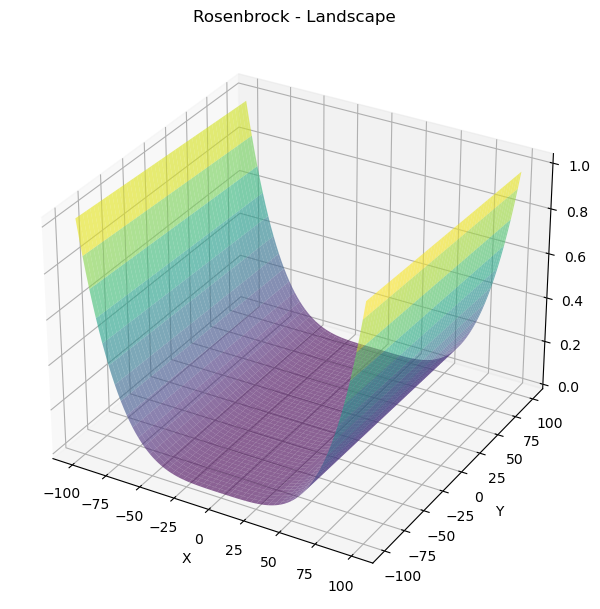

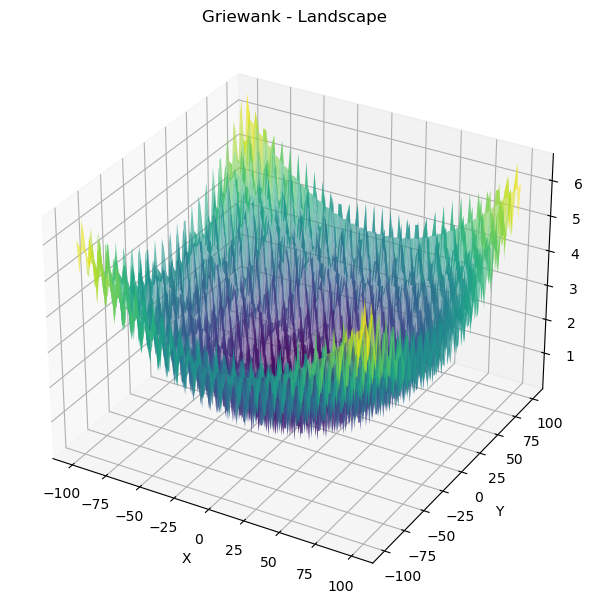

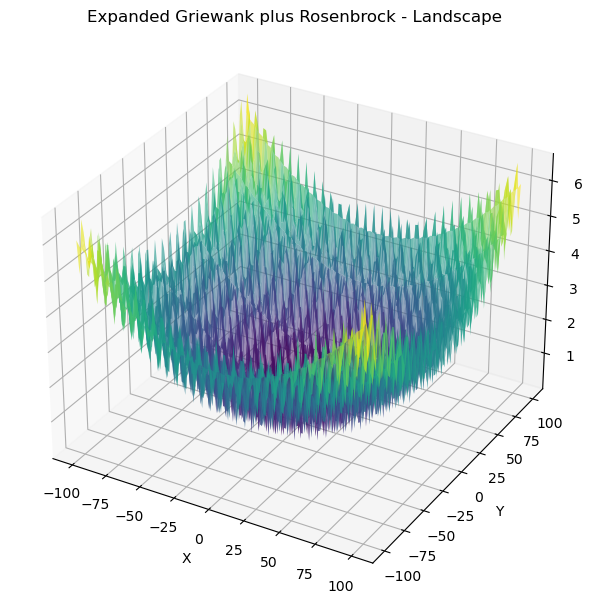

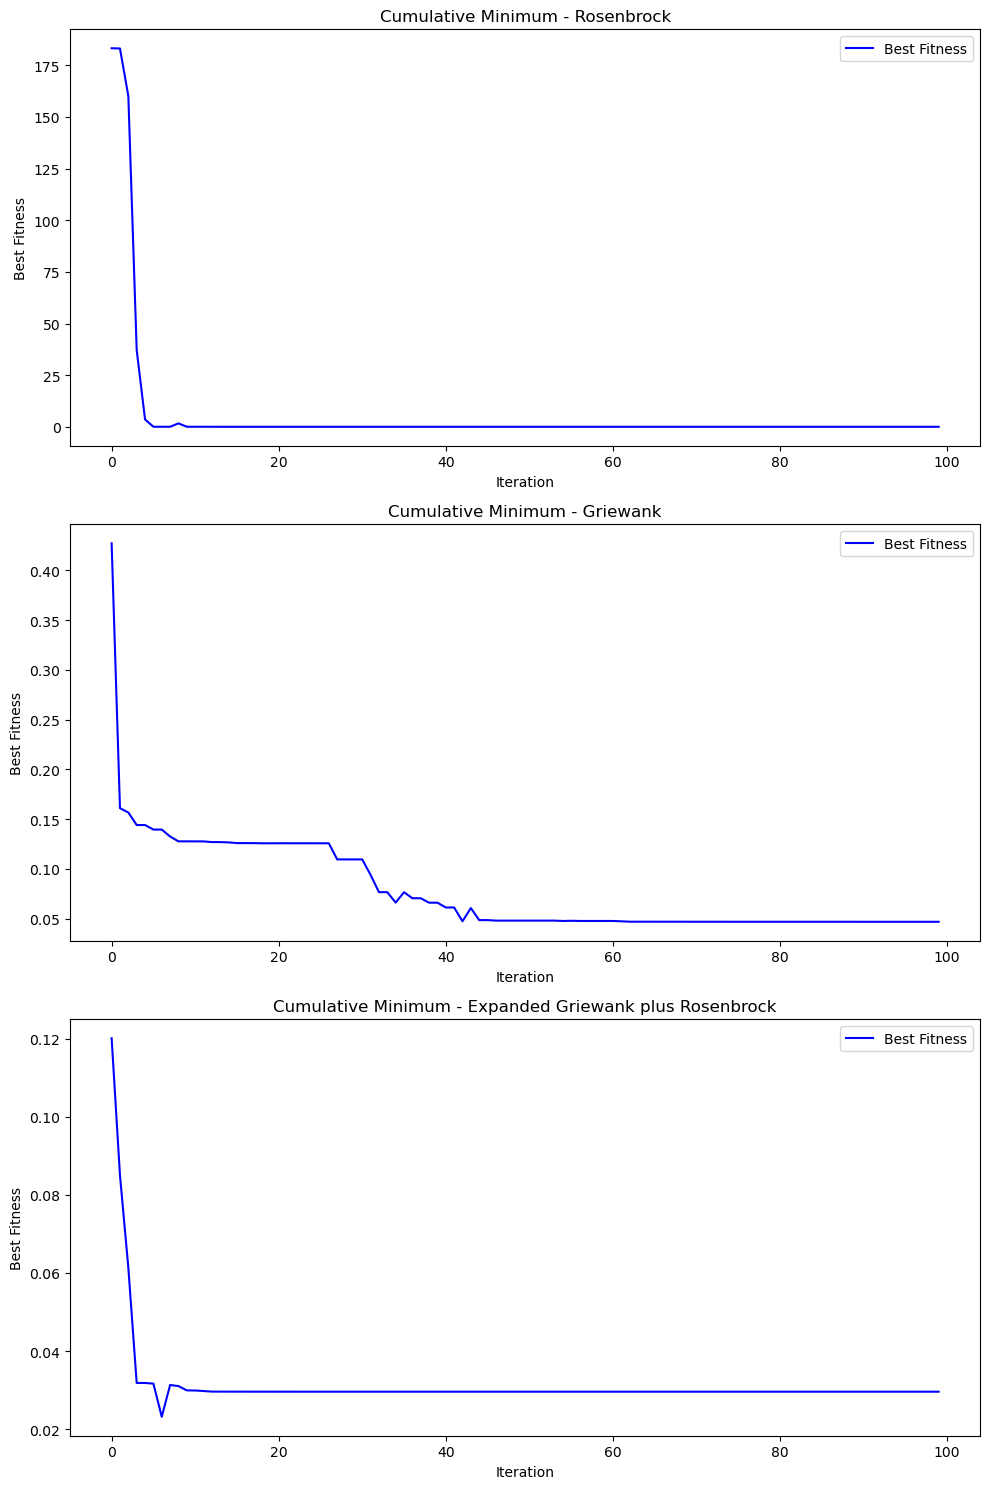

In [35]:
#최종

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sko.GA import GA
from mpl_toolkits.mplot3d import Axes3D

# 목적 함수 정의
def rosenbrock(p):
    p = np.array(p)
    return sum(100.0 * (p[1:] - p[:-1]**2.0)**2.0 + (1 - p[:-1])**2.0)

def griewank(p):
    p = np.array(p)
    part1 = sum([x**2 for x in p]) / 4000
    part2 = np.prod([np.cos(x / np.sqrt(i + 1)) for i, x in enumerate(p)])
    return 1 + part1 - part2

def expanded_griewank_plus_rosenbrock(p):
    p = np.array(p)
    part1 = sum([x**2 for x in p]) / 4000
    part2 = np.prod([np.cos(x / np.sqrt(i + 1)) for i, x in enumerate(p)])
    return 1 + part1 - part2

# Feng Shui GA 클래스
class FengShuiGA(GA):
    def __init__(self, func, n_dim, size_pop=100, max_iter=1000, prob_mut=0.01, lb=0, ub=10, prob_crossover=0.8, n_elitist=5):
        super().__init__(func=func, n_dim=n_dim, size_pop=size_pop, max_iter=max_iter, prob_mut=prob_mut, lb=lb, ub=ub)
        self.prob_crossover = prob_crossover
        self.best_fitness_over_time = []
        self.population_history = []
        self.n_elitist = n_elitist  # 엘리트 솔루션의 수

    def run(self, max_iter=None):
        self.max_iter = max_iter or self.max_iter
        for i in range(self.max_iter):
            self.X = self.chrom2x(self.Chrom)
            self.Y = self.x2y()
            self.ranking()
            self.selection()
            self.crossover()
            self.water_operator(i)
            self.mountain_operator(i)
            self.qi_operator(i)
            
            self.X = self.chrom2x(self.Chrom)
            self.Y = self.x2y()
            self.ranking()

            # 엘리트 솔루션 유지
            if self.n_elitist > 0:
                elite_idx = np.argsort(self.FitV)[-self.n_elitist:]
                self.elites = self.Chrom[elite_idx, :]

            # 최상의 솔루션 기록
            generation_best_index = self.FitV.argmax()
            self.generation_best_X.append(self.X[generation_best_index, :].copy())
            self.generation_best_Y.append(self.Y[generation_best_index])
            self.all_history_Y.append(self.Y.copy())
            self.all_history_FitV.append(self.FitV.copy())
            self.best_fitness_over_time.append(self.generation_best_Y[-1])
            self.population_history.append(self.Chrom.copy())

            # 엘리트 재삽입
            if self.n_elitist > 0:
                self.Chrom[:self.n_elitist, :] = self.elites

        global_best_index = np.array(self.generation_best_Y).argmin()
        self.best_x = self.generation_best_X[global_best_index]
        self.best_y = self.func(np.array([self.best_x]))
        return self.best_x, self.best_y

    def crossover(self):
        for i in range(0, self.size_pop, 2):
            if np.random.rand() > self.prob_crossover:
                continue
            Chrom1, Chrom2 = self.Chrom[i], self.Chrom[i + 1]
            n1 = np.random.randint(0, 2, self.n_dim).nonzero()[0]
            n2 = np.random.randint(0, 2, self.n_dim).nonzero()[0]
            if len(n1) == 0 or len(n2) == 0:
                continue
            for j in range(min(len(n1), len(n2))):
                n1_start, n1_end = n1[j], n2[j]
                if n1_start > n1_end:
                    n1_start, n1_end = n1_end, n1_start
                Chrom1[n1_start: n1_end], Chrom2[n1_start: n1_end] = Chrom2[n1_start: n1_end], Chrom1[n1_start: n1_end]
            self.Chrom[i], self.Chrom[i + 1] = Chrom1, Chrom2
        return self.Chrom

    def water_operator(self, iteration):
        dynamic_prob_mut = self.prob_mut * (1 - (iteration / self.max_iter))  # 적응형 돌연변이 비율
        mask = (np.random.rand(self.size_pop, self.len_chrom) < dynamic_prob_mut)
        self.Chrom = self.Chrom ^ mask

    def mountain_operator(self, iteration):
        if iteration % 5 == 0:  # 주기적으로 다양성 재도입
            num_mutations = int(self.size_pop * 0.1)  # 인구의 10%
            for _ in range(num_mutations):
                idx = np.random.randint(0, self.size_pop)
                self.Chrom[idx] = np.random.randint(0, 2, self.len_chrom)

    def qi_operator(self, iteration):
        # 탐색과 착취의 균형
        if iteration < self.max_iter / 2:
            # 더 많은 탐색
            self.prob_crossover = 0.9
        else:
            # 더 많은 착취
            self.prob_crossover = 0.6

# 최적화 및 플로팅
def optimize_and_plot(func, title):
    ga = FengShuiGA(func=func, n_dim=2, size_pop=100, max_iter=100, prob_mut=0.01, lb=[-100]*2, ub=[100]*2, n_elitist=0)
    best_x, best_y = ga.run()
    print(f'{title} - best_x:', best_x, '\n', 'best_y:', best_y)
    return pd.DataFrame(ga.best_fitness_over_time, columns=['Best Fitness']), ga.population_history

rosenbrock_history, rosenbrock_pop_history = optimize_and_plot(rosenbrock, 'Rosenbrock')
griewank_history, griewank_pop_history = optimize_and_plot(griewank, 'Griewank')
expanded_griewank_plus_rosenbrock_history, expanded_griewank_plus_rosenbrock_pop_history = optimize_and_plot(expanded_griewank_plus_rosenbrock, 'Expanded Griewank plus Rosenbrock')

# 3D 밀도 및 랜드스케이프 플로팅
def plot_3d_density_and_landscape(pop_history, func, title):
    fig = plt.figure(figsize=(12, 6))
    
    # 3D 랜드스케이프 플롯
    ax2 = fig.add_subplot(122, projection='3d')
    x_range = np.linspace(-100, 100, 100)
    y_range = np.linspace(-100, 100, 100)
    X, Y = np.meshgrid(x_range, y_range)
    Z = np.array([func([x, y]) for x, y in zip(X.flatten(), Y.flatten())]).reshape(X.shape)
    ax2.plot_surface(X, Y, Z, cmap='viridis', alpha=0.6)
    ax2.set_title(f'{title} - Landscape')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')

    plt.tight_layout()
    plt.show()

plot_3d_density_and_landscape(rosenbrock_pop_history, rosenbrock, 'Rosenbrock')
plot_3d_density_and_landscape(griewank_pop_history, griewank, 'Griewank')
plot_3d_density_and_landscape(expanded_griewank_plus_rosenbrock_pop_history, expanded_griewank_plus_rosenbrock, 'Expanded Griewank plus Rosenbrock')

# 최상의 적합도 변화를 시간에 따라 플로팅
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

def plot_fitness_over_time(history, ax, title):
    ax.plot(history.index, history.values, 'b-', label='Best Fitness')
    ax.set_title(f'Cumulative Minimum - {title}')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Best Fitness')
    ax.legend()

plot_fitness_over_time(rosenbrock_history, axs[0], 'Rosenbrock')
plot_fitness_over_time(griewank_history, axs[1], 'Griewank')
plot_fitness_over_time(expanded_griewank_plus_rosenbrock_history, axs[2], 'Expanded Griewank plus Rosenbrock')

plt.tight_layout()
plt.show()


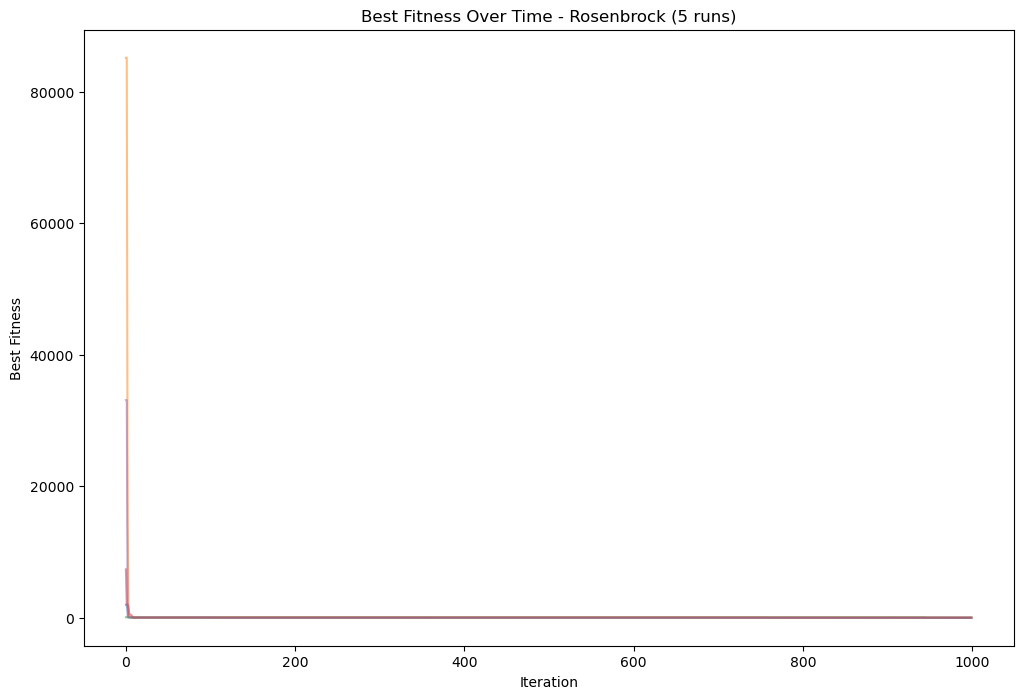

KeyboardInterrupt: 

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sko.GA import GA
from mpl_toolkits.mplot3d import Axes3D

# Define objective functions
def rosenbrock(p):
    p = np.array(p)
    return sum(100.0 * (p[1:] - p[:-1]**2.0)**2.0 + (1 - p[:-1])**2.0)

def griewank(p):
    p = np.array(p)
    part1 = sum([x**2 for x in p]) / 4000
    part2 = np.prod([np.cos(x / np.sqrt(i + 1)) for i, x in enumerate(p)])
    return 1 + part1 - part2

def expanded_griewank_plus_rosenbrock(p):
    p = np.array(p)
    part1 = sum([x**2 for x in p]) / 4000
    part2 = np.prod([np.cos(x / np.sqrt(i + 1)) for i, x in enumerate(p)])
    return 1 + part1 - part2

# Feng Shui GA Class
class FengShuiGA(GA):
    def __init__(self, func, n_dim, size_pop=100, max_iter=1000, prob_mut=0.01, lb=0, ub=10, prob_crossover=0.8, n_elitist=5):
        super().__init__(func=func, n_dim=n_dim, size_pop=size_pop, max_iter=max_iter, prob_mut=prob_mut, lb=lb, ub=ub)
        self.prob_crossover = prob_crossover
        self.best_fitness_over_time = []
        self.population_history = []
        self.n_elitist = n_elitist  # Number of elite solutions to retain

    def run(self, max_iter=None):
        self.max_iter = max_iter or self.max_iter
        for i in range(self.max_iter):
            self.X = self.chrom2x(self.Chrom)
            self.Y = self.x2y()
            self.ranking()
            self.selection()
            self.crossover()
            self.water_operator(i)
            self.mountain_operator(i)
            self.qi_operator(i)
            
            self.X = self.chrom2x(self.Chrom)
            self.Y = self.x2y()
            self.ranking()

            # Elitism: retain the best solutions
            if self.n_elitist > 0:
                elite_idx = np.argsort(self.FitV)[-self.n_elitist:]
                self.elites = self.Chrom[elite_idx, :]

            # record the best ones
            generation_best_index = self.FitV.argmax()
            self.generation_best_X.append(self.X[generation_best_index, :].copy())
            self.generation_best_Y.append(self.Y[generation_best_index])
            self.all_history_Y.append(self.Y.copy())
            self.all_history_FitV.append(self.FitV.copy())
            self.best_fitness_over_time.append(self.generation_best_Y[-1])
            self.population_history.append(self.Chrom.copy())

            # Re-insert elites
            if self.n_elitist > 0:
                self.Chrom[:self.n_elitist, :] = self.elites

        global_best_index = np.array(self.generation_best_Y).argmin()
        self.best_x = self.generation_best_X[global_best_index]
        self.best_y = self.func(np.array([self.best_x]))
        return self.best_x, self.best_y

    def crossover(self):
        for i in range(0, self.size_pop, 2):
            if np.random.rand() > self.prob_crossover:
                continue
            Chrom1, Chrom2 = self.Chrom[i], self.Chrom[i + 1]
            n1 = np.random.randint(0, 2, self.n_dim).nonzero()[0]
            n2 = np.random.randint(0, 2, self.n_dim).nonzero()[0]
            if len(n1) == 0 or len(n2) == 0:
                continue
            for j in range(min(len(n1), len(n2))):
                n1_start, n1_end = n1[j], n2[j]
                if n1_start > n1_end:
                    n1_start, n1_end = n1_end, n1_start
                Chrom1[n1_start: n1_end], Chrom2[n1_start: n1_end] = Chrom2[n1_start: n1_end], Chrom1[n1_start: n1_end]
            self.Chrom[i], self.Chrom[i + 1] = Chrom1, Chrom2
        return self.Chrom

    def water_operator(self, iteration):
        dynamic_prob_mut = self.prob_mut * (1 - (iteration / self.max_iter))  # Adaptive mutation rate
        mask = (np.random.rand(self.size_pop, self.len_chrom) < dynamic_prob_mut)
        self.Chrom = self.Chrom ^ mask

    def mountain_operator(self, iteration):
        if iteration % 5 == 0:  # Periodically reintroduce diversity
            num_mutations = int(self.size_pop * 0.1)  # 10% of the population
            for _ in range(num_mutations):
                idx = np.random.randint(0, self.size_pop)
                self.Chrom[idx] = np.random.randint(0, 2, self.len_chrom)

    def qi_operator(self, iteration):
        # Balancing exploration and exploitation
        if iteration < self.max_iter / 2:
            # More exploration
            self.prob_crossover = 0.9
        else:
            # More exploitation
            self.prob_crossover = 0.6

# 51 independent runs and plotting results
def multiple_runs_and_plot(func, title, n_runs=51):
    all_histories = []
    for i in range(n_runs):
        ga = FengShuiGA(func=func, n_dim=2, size_pop=100, max_iter=1000, prob_mut=0.01, lb=[-100]*2, ub=[100]*2, n_elitist=5)
        best_x, best_y = ga.run()
        all_histories.append(ga.best_fitness_over_time)
    
    plt.figure(figsize=(12, 8))
    for history in all_histories:
        plt.plot(history, alpha=0.5)
    plt.title(f'Best Fitness Over Time - {title} ({n_runs} runs)')
    plt.xlabel('Iteration')
    plt.ylabel('Best Fitness')
    plt.show()

# Run and plot for each objective function
multiple_runs_and_plot(rosenbrock, 'Rosenbrock')
multiple_runs_and_plot(griewank, 'Griewank')
multiple_runs_and_plot(expanded_griewank_plus_rosenbrock, 'Expanded Griewank plus Rosenbrock')


In [33]:
# Sensitivity analysis and results presentation
def sensitivity_analysis(func, title):
    results = []
    pcs = [0.7, 0.9]
    pms = [0.01, 0.05]

    for pc in pcs:
        for pm in pms:
            best_fitness_values = []
            for i in range(51):
                ga = FengShuiGA(func=func, n_dim=2, size_pop=100, max_iter=1000, prob_mut=pm, lb=[-100]*2, ub=[100]*2, prob_crossover=pc, n_elitist=5)
                best_x, best_y = ga.run()
                best_fitness_values.append(ga.best_fitness_over_time[-1])
            
            best = np.min(best_fitness_values)
            worst = np.max(best_fitness_values)
            mean = np.mean(best_fitness_values)
            std = np.std(best_fitness_values)
            results.append((title, pc, pm, best, worst, mean, std))
    
    return pd.DataFrame(results, columns=['Function', 'Pc', 'Pm', 'Best', 'Worst', 'Mean', 'SD'])

# Sensitivity analysis for each function
rosenbrock_sensitivity = sensitivity_analysis(rosenbrock, 'Rosenbrock')
griewank_sensitivity = sensitivity_analysis(griewank, 'Griewank')
expanded_griewank_plus_rosenbrock_sensitivity = sensitivity_analysis(expanded_griewank_plus_rosenbrock, 'Expanded Griewank plus Rosenbrock')

# Display sensitivity analysis results
print("Rosenbrock Function Sensitivity Analysis")
print(rosenbrock_sensitivity)
print("\nGriewank Function Sensitivity Analysis")
print(griewank_sensitivity)
print("\nExpanded Griewank plus Rosenbrock Function Sensitivity Analysis")
print(expanded_griewank_plus_rosenbrock_sensitivity)


Rosenbrock Function Sensitivity Analysis
     Function   Pc    Pm          Best      Worst       Mean         SD
0  Rosenbrock  0.7  0.01  9.008273e-04  51.021151   6.917429  10.470114
1  Rosenbrock  0.7  0.05  3.461893e-13  16.015176   0.767249   3.120033
2  Rosenbrock  0.9  0.01  1.271533e-07  64.325335  11.587541  17.146413
3  Rosenbrock  0.9  0.05  2.553759e-13   3.983468   0.127654   0.620233

Griewank Function Sensitivity Analysis
   Function   Pc    Pm          Best     Worst      Mean        SD
0  Griewank  0.7  0.01  1.665335e-15  0.046835  0.021175  0.017166
1  Griewank  0.7  0.05  1.665335e-15  0.046835  0.010489  0.011875
2  Griewank  0.9  0.01  1.665335e-15  0.046835  0.019817  0.018568
3  Griewank  0.9  0.05  1.665335e-15  0.046835  0.013244  0.014798

Expanded Griewank plus Rosenbrock Function Sensitivity Analysis
                            Function   Pc    Pm          Best     Worst  \
0  Expanded Griewank plus Rosenbrock  0.7  0.01  1.665335e-15  0.177475   
1  Expand

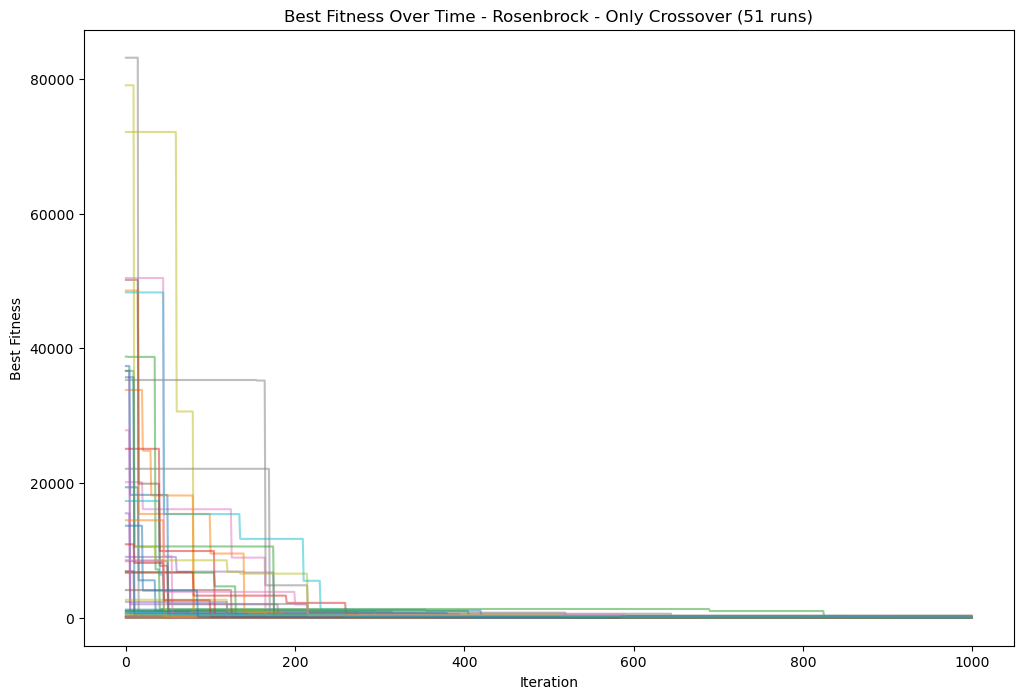

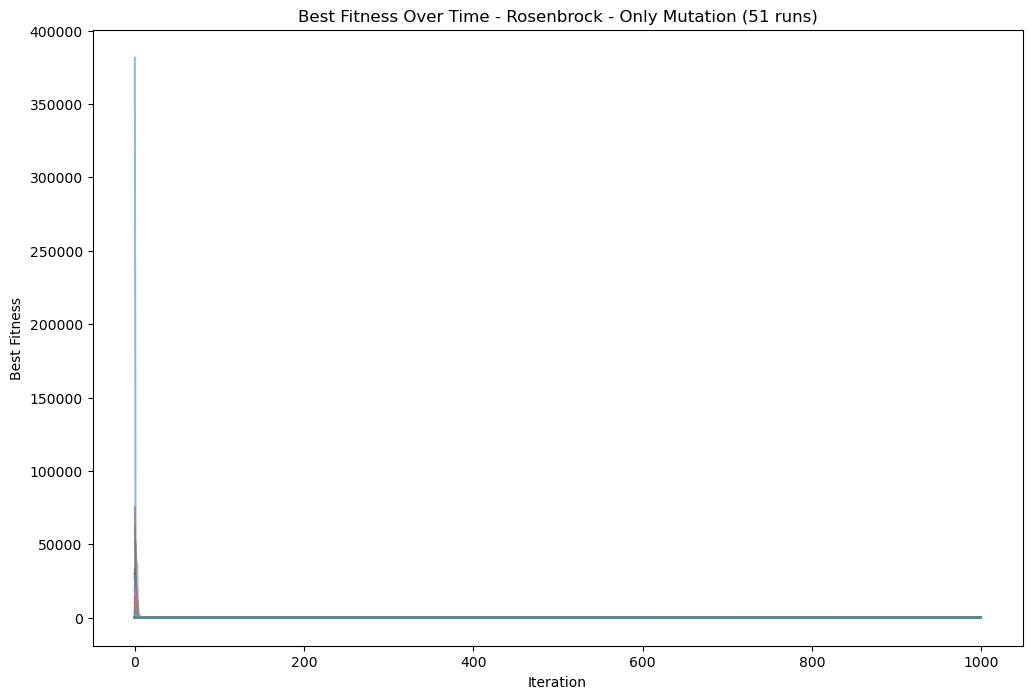

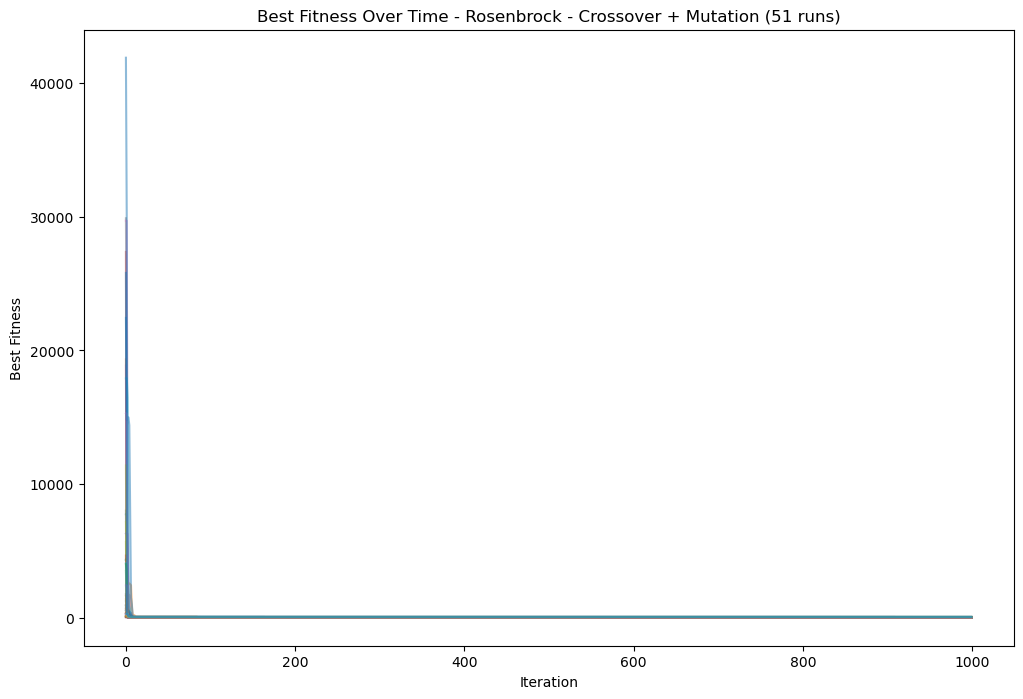

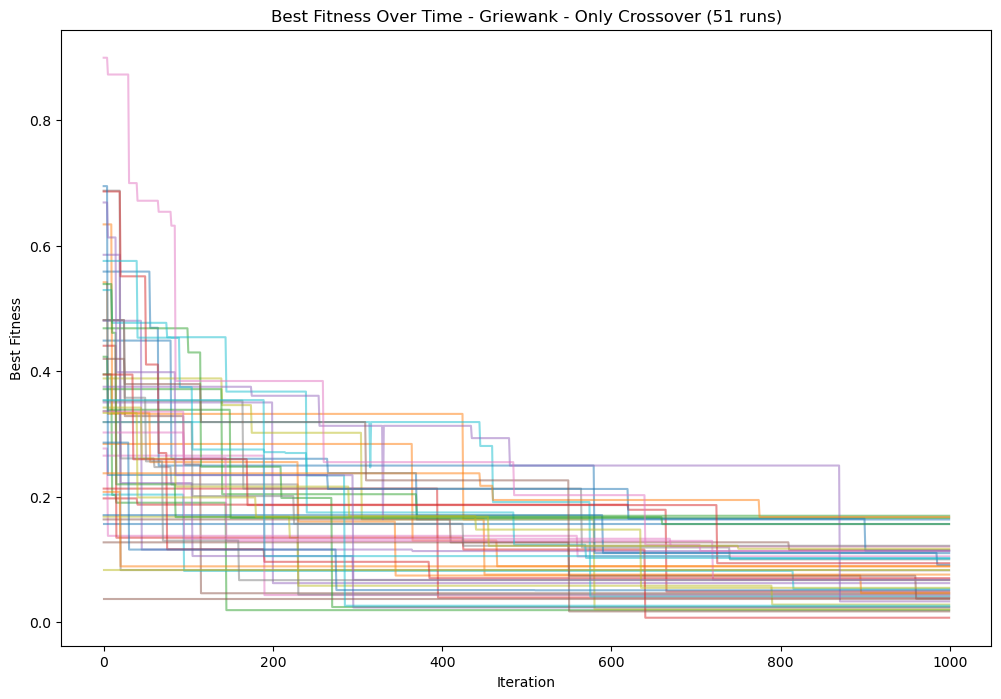

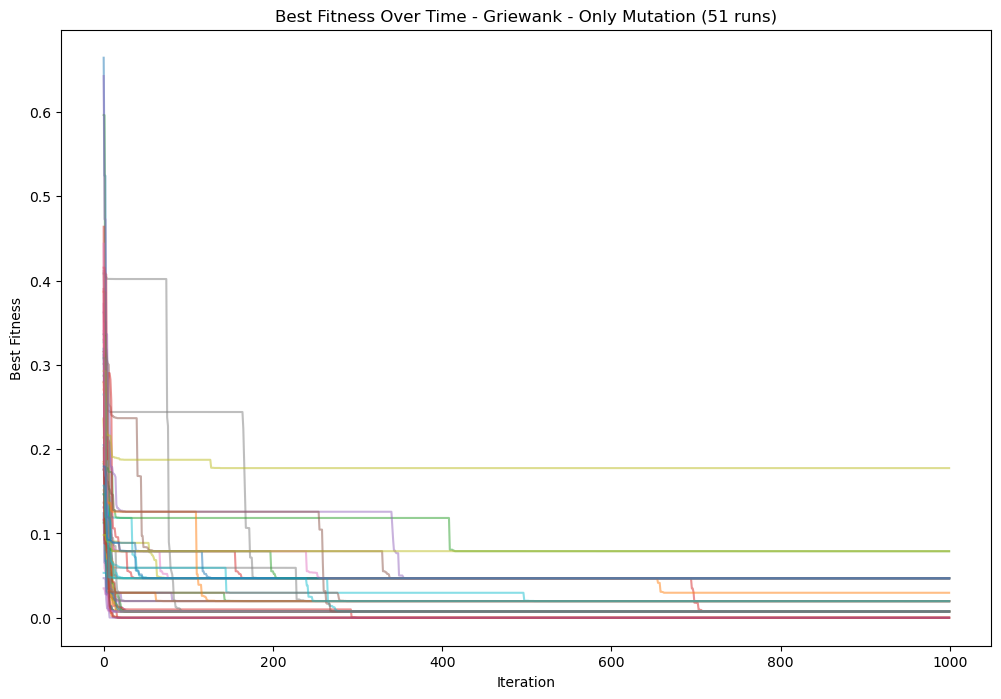

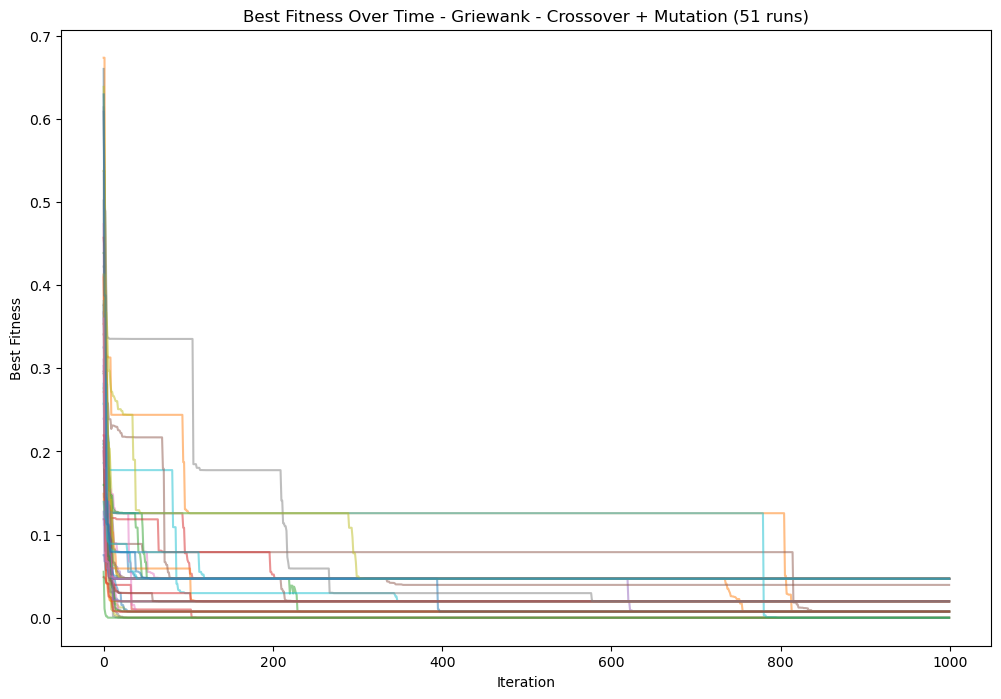

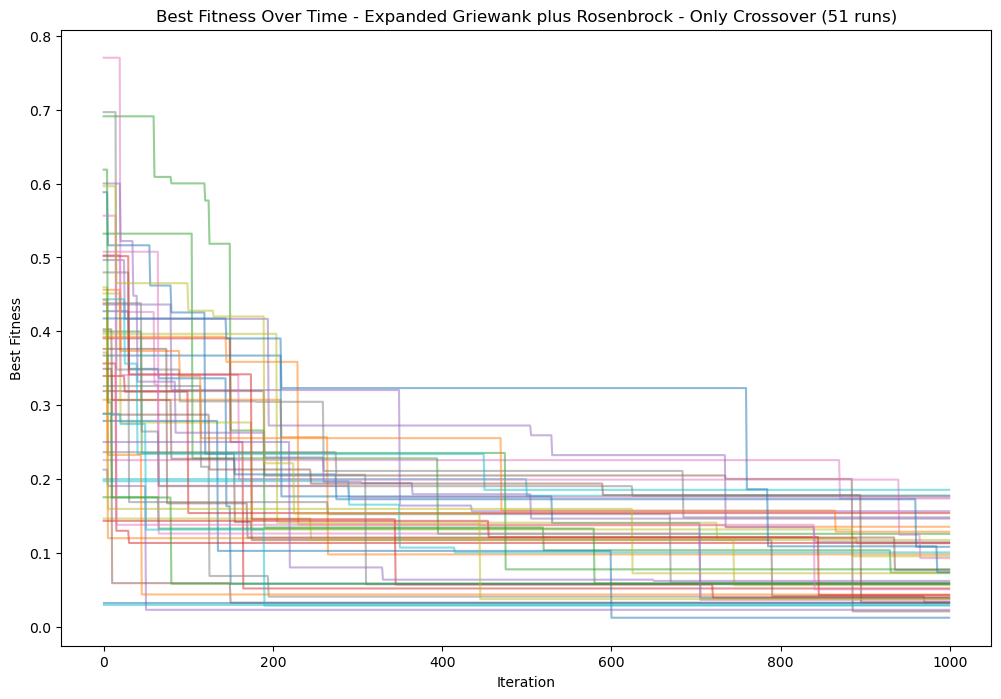

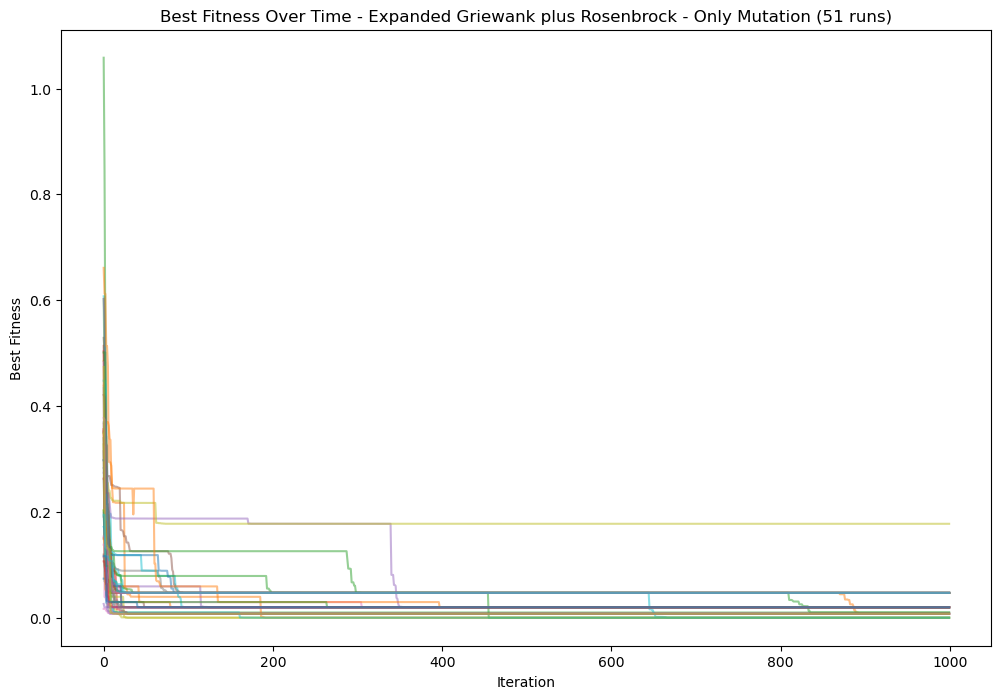

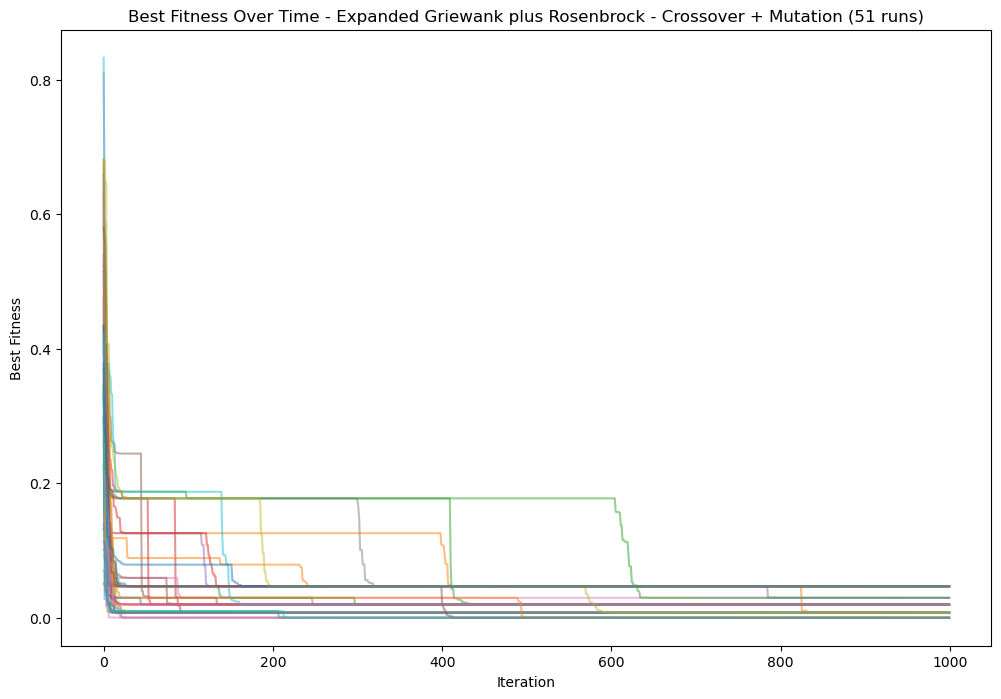

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sko.GA import GA
from mpl_toolkits.mplot3d import Axes3D

# Define objective functions
def rosenbrock(p):
    p = np.array(p)
    return sum(100.0 * (p[1:] - p[:-1]**2.0)**2.0 + (1 - p[:-1])**2.0)

def griewank(p):
    p = np.array(p)
    part1 = sum([x**2 for x in p]) / 4000
    part2 = np.prod([np.cos(x / np.sqrt(i + 1)) for i, x in enumerate(p)])
    return 1 + part1 - part2

def expanded_griewank_plus_rosenbrock(p):
    p = np.array(p)
    part1 = sum([x**2 for x in p]) / 4000
    part2 = np.prod([np.cos(x / np.sqrt(i + 1)) for i, x in enumerate(p)])
    return 1 + part1 - part2

# Feng Shui GA Class
class FengShuiGA(GA):
    def __init__(self, func, n_dim, size_pop=100, max_iter=1000, prob_mut=0.01, lb=0, ub=10, prob_crossover=0.8, n_elitist=5, use_crossover=True, use_mutation=True):
        super().__init__(func=func, n_dim=n_dim, size_pop=size_pop, max_iter=max_iter, prob_mut=prob_mut, lb=lb, ub=ub)
        self.prob_crossover = prob_crossover
        self.best_fitness_over_time = []
        self.population_history = []
        self.n_elitist = n_elitist  # Number of elite solutions to retain
        self.use_crossover = use_crossover
        self.use_mutation = use_mutation

    def run(self, max_iter=None):
        self.max_iter = max_iter or self.max_iter
        for i in range(self.max_iter):
            self.X = self.chrom2x(self.Chrom)
            self.Y = self.x2y()
            self.ranking()
            self.selection()
            if self.use_crossover:
                self.crossover()
            if self.use_mutation:
                self.water_operator(i)
            self.mountain_operator(i)
            self.qi_operator(i)
            
            self.X = self.chrom2x(self.Chrom)
            self.Y = self.x2y()
            self.ranking()

            # Elitism: retain the best solutions
            if self.n_elitist > 0:
                elite_idx = np.argsort(self.FitV)[-self.n_elitist:]
                self.elites = self.Chrom[elite_idx, :]

            # record the best ones
            generation_best_index = self.FitV.argmax()
            self.generation_best_X.append(self.X[generation_best_index, :].copy())
            self.generation_best_Y.append(self.Y[generation_best_index])
            self.all_history_Y.append(self.Y.copy())
            self.all_history_FitV.append(self.FitV.copy())
            self.best_fitness_over_time.append(self.generation_best_Y[-1])
            self.population_history.append(self.Chrom.copy())

            # Re-insert elites
            if self.n_elitist > 0:
                self.Chrom[:self.n_elitist, :] = self.elites

        global_best_index = np.array(self.generation_best_Y).argmin()
        self.best_x = self.generation_best_X[global_best_index]
        self.best_y = self.func(np.array([self.best_x]))
        return self.best_x, self.best_y

    def crossover(self):
        for i in range(0, self.size_pop, 2):
            if np.random.rand() > self.prob_crossover:
                continue
            Chrom1, Chrom2 = self.Chrom[i], self.Chrom[i + 1]
            n1 = np.random.randint(0, 2, self.n_dim).nonzero()[0]
            n2 = np.random.randint(0, 2, self.n_dim).nonzero()[0]
            if len(n1) == 0 or len(n2) == 0:
                continue
            for j in range(min(len(n1), len(n2))):
                n1_start, n1_end = n1[j], n2[j]
                if n1_start > n1_end:
                    n1_start, n1_end = n1_end, n1_start
                Chrom1[n1_start: n1_end], Chrom2[n1_start: n1_end] = Chrom2[n1_start: n1_end], Chrom1[n1_start: n1_end]
            self.Chrom[i], self.Chrom[i + 1] = Chrom1, Chrom2
        return self.Chrom

    def water_operator(self, iteration):
        dynamic_prob_mut = self.prob_mut * (1 - (iteration / self.max_iter))  # Adaptive mutation rate
        mask = (np.random.rand(self.size_pop, self.len_chrom) < dynamic_prob_mut)
        self.Chrom = self.Chrom ^ mask

    def mountain_operator(self, iteration):
        if iteration % 5 == 0:  # Periodically reintroduce diversity
            num_mutations = int(self.size_pop * 0.1)  # 10% of the population
            for _ in range(num_mutations):
                idx = np.random.randint(0, self.size_pop)
                self.Chrom[idx] = np.random.randint(0, 2, self.len_chrom)

    def qi_operator(self, iteration):
        # Balancing exploration and exploitation
        if iteration < self.max_iter / 2:
            # More exploration
            self.prob_crossover = 0.9
        else:
            # More exploitation
            self.prob_crossover = 0.6

# 51 independent runs and plotting results
def multiple_runs_and_plot(func, title, n_runs=51, use_crossover=True, use_mutation=True):
    all_histories = []
    for i in range(n_runs):
        ga = FengShuiGA(func=func, n_dim=2, size_pop=100, max_iter=1000, prob_mut=0.01, lb=[-100]*2, ub=[100]*2, n_elitist=5, use_crossover=use_crossover, use_mutation=use_mutation)
        best_x, best_y = ga.run()
        all_histories.append(ga.best_fitness_over_time)
    
    plt.figure(figsize=(12, 8))
    for history in all_histories:
        plt.plot(history, alpha=0.5)
    plt.title(f'Best Fitness Over Time - {title} ({n_runs} runs)')
    plt.xlabel('Iteration')
    plt.ylabel('Best Fitness')
    plt.show()

# Run and plot for each configuration
multiple_runs_and_plot(rosenbrock, 'Rosenbrock - Only Crossover', use_crossover=True, use_mutation=False)
multiple_runs_and_plot(rosenbrock, 'Rosenbrock - Only Mutation', use_crossover=False, use_mutation=True)
multiple_runs_and_plot(rosenbrock, 'Rosenbrock - Crossover + Mutation', use_crossover=True, use_mutation=True)

multiple_runs_and_plot(griewank, 'Griewank - Only Crossover', use_crossover=True, use_mutation=False)
multiple_runs_and_plot(griewank, 'Griewank - Only Mutation', use_crossover=False, use_mutation=True)
multiple_runs_and_plot(griewank, 'Griewank - Crossover + Mutation', use_crossover=True, use_mutation=True)

multiple_runs_and_plot(expanded_griewank_plus_rosenbrock, 'Expanded Griewank plus Rosenbrock - Only Crossover', use_crossover=True, use_mutation=False)
multiple_runs_and_plot(expanded_griewank_plus_rosenbrock, 'Expanded Griewank plus Rosenbrock - Only Mutation', use_crossover=False, use_mutation=True)
multiple_runs_and_plot(expanded_griewank_plus_rosenbrock, 'Expanded Griewank plus Rosenbrock - Crossover + Mutation', use_crossover=True, use_mutation=True)


In [38]:
import matplotlib.pyplot as plt

# 수식 정의 (LaTeX 형식)
latex_formula_expanded = r'$f(x, y) = \sum_{i=1}^{n-1} \left[ \frac{(x_{i+1} - x_i^2)^2}{4000} - \cos \left( \frac{x_i}{\sqrt{i}} \right) + 1 \right]$'
latex_formula_rosenbrock = r'$f(x, y) = 100 (y - x^2)^2 + (1 - x)^2$'
latex_formula_griewank = r'$f(x, y) = \frac{1}{4000} \sum_{i=1}^{n} x_i^2 - \prod_{i=1}^{n} \cos\left(\frac{x_i}{\sqrt{i}}\right) + 1$'

# 이미지 크기 설정
plt.figure(figsize=(10, 2))
plt.text(0.5, 0.5, latex_formula_expanded, horizontalalignment='center', verticalalignment='center', fontsize=20)
plt.axis('off')
plt.savefig('expanded_griewank_rosenbrock_formula.png', dpi=300, bbox_inches='tight', transparent=True)
plt.close()

plt.figure(figsize=(10, 2))
plt.text(0.5, 0.5, latex_formula_rosenbrock, horizontalalignment='center', verticalalignment='center', fontsize=20)
plt.axis('off')
plt.savefig('rosenbrock_formula.png', dpi=300, bbox_inches='tight', transparent=True)
plt.close()

plt.figure(figsize=(10, 2))
plt.text(0.5, 0.5, latex_formula_griewank, horizontalalignment='center', verticalalignment='center', fontsize=20)
plt.axis('off')
plt.savefig('griewank_formula.png', dpi=300, bbox_inches='tight', transparent=True)
plt.close()


In [42]:
# #모든 경우의 수

# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sko.GA import GA

# # Define objective functions
# def rosenbrock(p):
#     p = np.array(p)
#     return sum(100.0 * (p[1:] - p[:-1]**2.0)**2.0 + (1 - p[:-1])**2.0)

# def griewank(p):
#     p = np.array(p)
#     part1 = sum([x**2 for x in p]) / 4000
#     part2 = np.prod([np.cos(x / np.sqrt(i + 1)) for i, x in enumerate(p)])
#     return 1 + part1 - part2

# def expanded_griewank_plus_rosenbrock(p):
#     p = np.array(p)
#     part1 = sum([x**2 for x in p]) / 4000
#     part2 = np.prod([np.cos(x / np.sqrt(i + 1)) for i, x in enumerate(p)])
#     return 1 + part1 - part2

# # Feng Shui GA Class with selectable operators
# class FengShuiGAWithOperators(GA):
#     def __init__(self, func, n_dim, size_pop=100, max_iter=100, prob_mut=0.01, lb=0, ub=10, prob_crossover=0.8, n_elitist=5,
#                  use_water=True, use_mountain=True, use_qi=True):
#         super().__init__(func=func, n_dim=n_dim, size_pop=size_pop, max_iter=max_iter, prob_mut=prob_mut, lb=lb, ub=ub)
#         self.prob_crossover = prob_crossover
#         self.best_fitness_over_time = []
#         self.population_history = []
#         self.n_elitist = n_elitist  # Number of elite solutions to retain
#         self.use_water = use_water
#         self.use_mountain = use_mountain
#         self.use_qi = use_qi

#     def run(self, max_iter=None):
#         self.max_iter = max_iter or self.max_iter
#         for i in range(self.max_iter):
#             self.X = self.chrom2x(self.Chrom)
#             self.Y = self.x2y()
#             self.ranking()
#             self.selection()
#             self.crossover()
#             if self.use_water:
#                 self.water_operator(i)
#             if self.use_mountain:
#                 self.mountain_operator(i)
#             if self.use_qi:
#                 self.qi_operator(i)
            
#             self.X = self.chrom2x(self.Chrom)
#             self.Y = self.x2y()
#             self.ranking()

#             # Elitism: retain the best solutions
#             if self.n_elitist > 0:
#                 elite_idx = np.argsort(self.FitV)[-self.n_elitist:]
#                 self.elites = self.Chrom[elite_idx, :]

#             # record the best ones
#             generation_best_index = self.FitV.argmax()
#             self.generation_best_X.append(self.X[generation_best_index, :].copy())
#             self.generation_best_Y.append(self.Y[generation_best_index])
#             self.all_history_Y.append(self.Y.copy())
#             self.all_history_FitV.append(self.FitV.copy())
#             self.best_fitness_over_time.append(self.generation_best_Y[-1])
#             self.population_history.append(self.Chrom.copy())

#             # Re-insert elites
#             if self.n_elitist > 0:
#                 self.Chrom[:self.n_elitist, :] = self.elites

#         global_best_index = np.array(self.generation_best_Y).argmin()
#         self.best_x = self.generation_best_X[global_best_index]
#         self.best_y = self.func(np.array([self.best_x]))
#         return self.best_x, self.best_y

#     def crossover(self):
#         for i in range(0, self.size_pop, 2):
#             if np.random.rand() > self.prob_crossover:
#                 continue
#             Chrom1, Chrom2 = self.Chrom[i], self.Chrom[i + 1]
#             n1 = np.random.randint(0, 2, self.n_dim).nonzero()[0]
#             n2 = np.random.randint(0, 2, self.n_dim).nonzero()[0]
#             if len(n1) == 0 or len(n2) == 0:
#                 continue
#             for j in range(min(len(n1), len(n2))):
#                 n1_start, n1_end = n1[j], n2[j]
#                 if n1_start > n1_end:
#                     n1_start, n1_end = n1_end, n1_start
#                 Chrom1[n1_start: n1_end], Chrom2[n1_start: n1_end] = Chrom2[n1_start: n1_end], Chrom1[n1_start: n1_end]
#             self.Chrom[i], self.Chrom[i + 1] = Chrom1, Chrom2
#         return self.Chrom

#     def water_operator(self, iteration):
#         dynamic_prob_mut = self.prob_mut * (1 - (iteration / self.max_iter))  # Adaptive mutation rate
#         mask = (np.random.rand(self.size_pop, self.len_chrom) < dynamic_prob_mut)
#         self.Chrom = self.Chrom ^ mask

#     def mountain_operator(self, iteration):
#         if iteration % 5 == 0:  # Periodically reintroduce diversity
#             num_mutations = int(self.size_pop * 0.1)  # 10% of the population
#             for _ in range(num_mutations):
#                 idx = np.random.randint(0, self.size_pop)
#                 self.Chrom[idx] = np.random.randint(0, 2, self.len_chrom)

#     def qi_operator(self, iteration):
#         # Balancing exploration and exploitation
#         if iteration < self.max_iter / 2:
#             # More exploration
#             self.prob_crossover = 0.9
#         else:
#             # More exploitation
#             self.prob_crossover = 0.6

# # Sensitivity analysis and results presentation
# def sensitivity_analysis(func, title):
#     results = []
#     pcs = [0.7, 0.9]
#     pms = [0.01, 0.05]
#     operator_combinations = [
#         ("Water", True, False, False),
#         ("Mountain", False, True, False),
#         ("Qi", False, False, True),
#         ("Water + Mountain", True, True, False),
#         ("Water + Qi", True, False, True),
#         ("Mountain + Qi", False, True, True),
#         ("Water + Mountain + Qi", True, True, True)
#     ]

#     for op_name, use_water, use_mountain, use_qi in operator_combinations:
#         for pc in pcs:
#             for pm in pms:
#                 best_fitness_values = []
#                 for i in range(5):
#                     ga = FengShuiGAWithOperators(func=func, n_dim=2, size_pop=100, max_iter=100, prob_mut=pm, lb=[-100]*2, ub=[100]*2,
#                                                  prob_crossover=pc, n_elitist=5, use_water=use_water, use_mountain=use_mountain, use_qi=use_qi)
#                     best_x, best_y = ga.run()
#                     best_fitness_values.append(ga.best_fitness_over_time[-1])

#                 best = np.min(best_fitness_values)
#                 worst = np.max(best_fitness_values)
#                 mean = np.mean(best_fitness_values)
#                 std = np.std(best_fitness_values)
#                 results.append((title, op_name, pc, pm, best, worst, mean, std))

#     return pd.DataFrame(results, columns=['Function', 'Operators', 'Pc', 'Pm', 'Best', 'Worst', 'Mean', 'SD'])

# # Sensitivity analysis for each function
# rosenbrock_sensitivity = sensitivity_analysis(rosenbrock, 'Rosenbrock')
# griewank_sensitivity = sensitivity_analysis(griewank, 'Griewank')
# expanded_griewank_plus_rosenbrock_sensitivity = sensitivity_analysis(expanded_griewank_plus_rosenbrock, 'Expanded Griewank plus Rosenbrock')

# # Display sensitivity analysis results
# print("Rosenbrock Function Sensitivity Analysis")
# print(rosenbrock_sensitivity)
# print("\nGriewank Function Sensitivity Analysis")
# print(griewank_sensitivity)
# print("\nExpanded Griewank plus Rosenbrock Function Sensitivity Analysis")
# print(expanded_griewank_plus_rosenbrock_sensitivity)


KeyboardInterrupt: 

In [47]:
#모든 경우의 수


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sko.GA import GA
from tqdm import tqdm

# Define objective functions
def rosenbrock(p):
    p = np.array(p)
    return sum(100.0 * (p[1:] - p[:-1]**2.0)**2.0 + (1 - p[:-1])**2.0)

def griewank(p):
    p = np.array(p)
    part1 = sum([x**2 for x in p]) / 4000
    part2 = np.prod([np.cos(x / np.sqrt(i + 1)) for i, x in enumerate(p)])
    return 1 + part1 - part2

def expanded_griewank_plus_rosenbrock(p):
    p = np.array(p)
    part1 = sum([x**2 for x in p]) / 4000
    part2 = np.prod([np.cos(x / np.sqrt(i + 1)) for i, x in enumerate(p)])
    return 1 + part1 - part2

# Feng Shui GA Class with selectable operators
class FengShuiGAWithOperators(GA):
    def __init__(self, func, n_dim, size_pop=100, max_iter=1000, prob_mut=0.01, lb=0, ub=10, prob_crossover=0.8, n_elitist=5,
                 use_water=True, use_mountain=True, use_qi=True):
        super().__init__(func=func, n_dim=n_dim, size_pop=size_pop, max_iter=max_iter, prob_mut=prob_mut, lb=lb, ub=ub)
        self.prob_crossover = prob_crossover
        self.best_fitness_over_time = []
        self.population_history = []
        self.n_elitist = n_elitist  # Number of elite solutions to retain
        self.use_water = use_water
        self.use_mountain = use_mountain
        self.use_qi = use_qi

    def run(self, max_iter=None):
        self.max_iter = max_iter or self.max_iter
        for i in range(self.max_iter):
            self.X = self.chrom2x(self.Chrom)
            self.Y = self.x2y()
            self.ranking()
            self.selection()
            self.crossover()
            if self.use_water:
                self.water_operator(i)
            if self.use_mountain:
                self.mountain_operator(i)
            if self.use_qi:
                self.qi_operator(i)
            
            self.X = self.chrom2x(self.Chrom)
            self.Y = self.x2y()
            self.ranking()

            # Elitism: retain the best solutions
            if self.n_elitist > 0:
                elite_idx = np.argsort(self.FitV)[-self.n_elitist:]
                self.elites = self.Chrom[elite_idx, :]

            # record the best ones
            generation_best_index = self.FitV.argmax()
            self.generation_best_X.append(self.X[generation_best_index, :].copy())
            self.generation_best_Y.append(self.Y[generation_best_index])
            self.all_history_Y.append(self.Y.copy())
            self.all_history_FitV.append(self.FitV.copy())
            self.best_fitness_over_time.append(self.generation_best_Y[-1])
            self.population_history.append(self.Chrom.copy())

            # Re-insert elites
            if self.n_elitist > 0:
                self.Chrom[:self.n_elitist, :] = self.elites

        global_best_index = np.array(self.generation_best_Y).argmin()
        self.best_x = self.generation_best_X[global_best_index]
        self.best_y = self.func(np.array([self.best_x]))
        return self.best_x, self.best_y

    def crossover(self):
        for i in range(0, self.size_pop, 2):
            if np.random.rand() > self.prob_crossover:
                continue
            Chrom1, Chrom2 = self.Chrom[i], self.Chrom[i + 1]
            n1 = np.random.randint(0, 2, self.n_dim).nonzero()[0]
            n2 = np.random.randint(0, 2, self.n_dim).nonzero()[0]
            if len(n1) == 0 or len(n2) == 0:
                continue
            for j in range(min(len(n1), len(n2))):
                n1_start, n1_end = n1[j], n2[j]
                if n1_start > n1_end:
                    n1_start, n1_end = n1_end, n1_start
                Chrom1[n1_start: n1_end], Chrom2[n1_start: n1_end] = Chrom2[n1_start: n1_end], Chrom1[n1_start: n1_end]
            self.Chrom[i], self.Chrom[i + 1] = Chrom1, Chrom2
        return self.Chrom

    def water_operator(self, iteration):
        dynamic_prob_mut = self.prob_mut * (1 - (iteration / self.max_iter))  # Adaptive mutation rate
        mask = (np.random.rand(self.size_pop, self.len_chrom) < dynamic_prob_mut)
        self.Chrom = self.Chrom ^ mask

    def mountain_operator(self, iteration):
        if iteration % 5 == 0:  # Periodically reintroduce diversity
            num_mutations = int(self.size_pop * 0.1)  # 10% of the population
            for _ in range(num_mutations):
                idx = np.random.randint(0, self.size_pop)
                self.Chrom[idx] = np.random.randint(0, 2, self.len_chrom)

    def qi_operator(self, iteration):
        # Balancing exploration and exploitation
        if iteration < self.max_iter / 2:
            # More exploration
            self.prob_crossover = 0.9
        else:
            # More exploitation
            self.prob_crossover = 0.6

# Sensitivity analysis and results presentation
def sensitivity_analysis(func, title):
    results = []
    pcs = [0.7, 0.9]
    pms = [0.01, 0.05]
    operator_combinations = [
        ("Water", True, False, False),
        ("Mountain", False, True, False),
        ("Qi", False, False, True),
        ("Water + Mountain", True, True, False),
        ("Water + Qi", True, False, True),
        ("Mountain + Qi", False, True, True),
        ("Water + Mountain + Qi", True, True, True)
    ]

    total_iterations = len(operator_combinations) * len(pcs) * len(pms) * 51 #51
    progress_bar = tqdm(total=total_iterations, desc='Sensitivity Analysis Progress')

    for op_name, use_water, use_mountain, use_qi in operator_combinations:
        for pc in pcs:
            for pm in pms:
                best_fitness_values = []
                for i in range(51):
                    ga = FengShuiGAWithOperators(func=func, n_dim=2, size_pop=100, max_iter=1000, prob_mut=pm, lb=[-100]*2, ub=[100]*2,
                                                 prob_crossover=pc, n_elitist=5, use_water=use_water, use_mountain=use_mountain, use_qi=use_qi)
                    best_x, best_y = ga.run()
                    best_fitness_values.append(ga.best_fitness_over_time[-1])
                    progress_bar.update(1)
                best = np.min(best_fitness_values)
                worst = np.max(best_fitness_values)
                mean = np.mean(best_fitness_values)
                std = np.std(best_fitness_values)
                results.append((title, op_name, pc, pm, best, worst, mean, std))
    
    progress_bar.close()
    return pd.DataFrame(results, columns=['Function', 'Operators', 'Pc', 'Pm', 'Best', 'Worst', 'Mean', 'SD'])

# Sensitivity analysis for each function
rosenbrock_sensitivity = sensitivity_analysis(rosenbrock, 'Rosenbrock')
griewank_sensitivity = sensitivity_analysis(griewank, 'Griewank')
expanded_griewank_plus_rosenbrock_sensitivity = sensitivity_analysis(expanded_griewank_plus_rosenbrock, 'Expanded Griewank plus Rosenbrock')

# Display sensitivity analysis results
print("Rosenbrock Function Sensitivity Analysis")
print(rosenbrock_sensitivity)
print("\nGriewank Function Sensitivity Analysis")
print(griewank_sensitivity)
print("\nExpanded Griewank plus Rosenbrock Function Sensitivity Analysis")
print(expanded_griewank_plus_rosenbrock_sensitivity)


Rosenbrock Function Sensitivity Analysis
      Function              Operators   Pc    Pm          Best          Worst  \
0   Rosenbrock                  Water  0.7  0.01  1.239489e-04      75.200418   
1   Rosenbrock                  Water  0.7  0.05  2.355529e-12      15.980918   
2   Rosenbrock                  Water  0.9  0.01  1.165521e-03      71.426048   
3   Rosenbrock                  Water  0.9  0.05  6.559627e-14       0.378816   
4   Rosenbrock               Mountain  0.7  0.01  1.275137e-01     563.906271   
5   Rosenbrock               Mountain  0.7  0.05  4.013518e-01     441.400683   
6   Rosenbrock               Mountain  0.9  0.01  1.290303e+00    1282.117123   
7   Rosenbrock               Mountain  0.9  0.05  6.180809e-01     410.136285   
8   Rosenbrock                     Qi  0.7  0.01  5.624548e-01  145598.878127   
9   Rosenbrock                     Qi  0.7  0.05  6.514012e+01  361544.774851   
10  Rosenbrock                     Qi  0.9  0.01  6.460026e+00  5445

In [48]:
# 위 코드에 대한 모든 플롯 생성

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sko.GA import GA
from tqdm import tqdm

# Define objective functions
def rosenbrock(p):
    p = np.array(p)
    return sum(100.0 * (p[1:] - p[:-1]**2.0)**2.0 + (1 - p[:-1])**2.0)

def griewank(p):
    p = np.array(p)
    part1 = sum([x**2 for x in p]) / 4000
    part2 = np.prod([np.cos(x / np.sqrt(i + 1)) for i, x in enumerate(p)])
    return 1 + part1 - part2

def expanded_griewank_plus_rosenbrock(p):
    p = np.array(p)
    part1 = sum([x**2 for x in p]) / 4000
    part2 = np.prod([np.cos(x / np.sqrt(i + 1)) for i, x in enumerate(p)])
    return 1 + part1 - part2

# Feng Shui GA Class with selectable operators
class FengShuiGAWithOperators(GA):
    def __init__(self, func, n_dim, size_pop=100, max_iter=1000, prob_mut=0.01, lb=0, ub=10, prob_crossover=0.8, n_elitist=5,
                 use_water=True, use_mountain=True, use_qi=True):
        super().__init__(func=func, n_dim=n_dim, size_pop=size_pop, max_iter=max_iter, prob_mut=prob_mut, lb=lb, ub=ub)
        self.prob_crossover = prob_crossover
        self.best_fitness_over_time = []
        self.population_history = []
        self.n_elitist = n_elitist  # Number of elite solutions to retain
        self.use_water = use_water
        self.use_mountain = use_mountain
        self.use_qi = use_qi

    def run(self, max_iter=None):
        self.max_iter = max_iter or self.max_iter
        for i in range(self.max_iter):
            self.X = self.chrom2x(self.Chrom)
            self.Y = self.x2y()
            self.ranking()
            self.selection()
            self.crossover()
            if self.use_water:
                self.water_operator(i)
            if self.use_mountain:
                self.mountain_operator(i)
            if self.use_qi:
                self.qi_operator(i)
            
            self.X = self.chrom2x(self.Chrom)
            self.Y = self.x2y()
            self.ranking()

            # Elitism: retain the best solutions
            if self.n_elitist > 0:
                elite_idx = np.argsort(self.FitV)[-self.n_elitist:]
                self.elites = self.Chrom[elite_idx, :]

            # record the best ones
            generation_best_index = self.FitV.argmax()
            self.generation_best_X.append(self.X[generation_best_index, :].copy())
            self.generation_best_Y.append(self.Y[generation_best_index])
            self.all_history_Y.append(self.Y.copy())
            self.all_history_FitV.append(self.FitV.copy())
            self.best_fitness_over_time.append(self.generation_best_Y[-1])
            self.population_history.append(self.Chrom.copy())

            # Re-insert elites
            if self.n_elitist > 0:
                self.Chrom[:self.n_elitist, :] = self.elites

        global_best_index = np.array(self.generation_best_Y).argmin()
        self.best_x = self.generation_best_X[global_best_index]
        self.best_y = self.func(np.array([self.best_x]))
        return self.best_x, self.best_y

    def crossover(self):
        for i in range(0, self.size_pop, 2):
            if np.random.rand() > self.prob_crossover:
                continue
            Chrom1, Chrom2 = self.Chrom[i], self.Chrom[i + 1]
            n1 = np.random.randint(0, 2, self.n_dim).nonzero()[0]
            n2 = np.random.randint(0, 2, self.n_dim).nonzero()[0]
            if len(n1) == 0 or len(n2) == 0:
                continue
            for j in range(min(len(n1), len(n2))):
                n1_start, n1_end = n1[j], n2[j]
                if n1_start > n1_end:
                    n1_start, n1_end = n1_end, n1_start
                Chrom1[n1_start: n1_end], Chrom2[n1_start: n1_end] = Chrom2[n1_start: n1_end], Chrom1[n1_start: n1_end]
            self.Chrom[i], self.Chrom[i + 1] = Chrom1, Chrom2
        return self.Chrom

    def water_operator(self, iteration):
        dynamic_prob_mut = self.prob_mut * (1 - (iteration / self.max_iter))  # Adaptive mutation rate
        mask = (np.random.rand(self.size_pop, self.len_chrom) < dynamic_prob_mut)
        self.Chrom = self.Chrom ^ mask

    def mountain_operator(self, iteration):
        if iteration % 5 == 0:  # Periodically reintroduce diversity
            num_mutations = int(self.size_pop * 0.1)  # 10% of the population
            for _ in range(num_mutations):
                idx = np.random.randint(0, self.size_pop)
                self.Chrom[idx] = np.random.randint(0, 2, self.len_chrom)

    def qi_operator(self, iteration):
        # Balancing exploration and exploitation
        if iteration < self.max_iter / 2:
            # More exploration
            self.prob_crossover = 0.9
        else:
            # More exploitation
            self.prob_crossover = 0.6

# Sensitivity analysis and results presentation
def sensitivity_analysis(func, title):
    results = []
    pcs = [0.7, 0.9]
    pms = [0.01, 0.05]
    operator_combinations = [
        ("Water", True, False, False),
        ("Mountain", False, True, False),
        ("Qi", False, False, True),
        ("Water + Mountain", True, True, False),
        ("Water + Qi", True, False, True),
        ("Mountain + Qi", False, True, True),
        ("Water + Mountain + Qi", True, True, True)
    ]

    total_iterations = len(operator_combinations) * len(pcs) * len(pms) * 51
    progress_bar = tqdm(total=total_iterations, desc='Sensitivity Analysis Progress')

    for op_name, use_water, use_mountain, use_qi in operator_combinations:
        for pc in pcs:
            for pm in pms:
                best_fitness_values = []
                for i in range(51):
                    ga = FengShuiGAWithOperators(func=func, n_dim=2, size_pop=100, max_iter=1000, prob_mut=pm, lb=[-100]*2, ub=[100]*2,
                                                 prob_crossover=pc, n_elitist=5, use_water=use_water, use_mountain=use_mountain, use_qi=use_qi)
                    best_x, best_y = ga.run()
                    best_fitness_values.append(ga.best_fitness_over_time[-1])
                    progress_bar.update(1)
                best = np.min(best_fitness_values)
                worst = np.max(best_fitness_values)
                mean = np.mean(best_fitness_values)
                std = np.std(best_fitness_values)
                results.append((title, op_name, pc, pm, best, worst, mean, std))
                
                # Plotting
                plt.figure()
                plt.plot(ga.best_fitness_over_time, label='Best Fitness Over Time')
                plt.xlabel('Iteration')
                plt.ylabel('Best Fitness')
                plt.title(f'{title} - {op_name} - Pc: {pc}, Pm: {pm}')
                plt.legend()
                plt.savefig(f'{title}_{op_name}_Pc{pc}_Pm{pm}.png')
                plt.close()
    
    progress_bar.close()
    return pd.DataFrame(results, columns=['Function', 'Operators', 'Pc', 'Pm', 'Best', 'Worst', 'Mean', 'SD'])

# Sensitivity analysis for each function
rosenbrock_sensitivity = sensitivity_analysis(rosenbrock, 'Rosenbrock')
griewank_sensitivity = sensitivity_analysis(griewank, 'Griewank')
expanded_griewank_plus_rosenbrock_sensitivity = sensitivity_analysis(expanded_griewank_plus_rosenbrock, 'Expanded Griewank plus Rosenbrock')

# Display sensitivity analysis results
print("Rosenbrock Function Sensitivity Analysis")
print(rosenbrock_sensitivity)
print("\nGriewank Function Sensitivity Analysis")
print(griewank_sensitivity)
print("\nExpanded Griewank plus Rosenbrock Function Sensitivity Analysis")
print(expanded_griewank_plus_rosenbrock_sensitivity)


Rosenbrock Function Sensitivity Analysis
      Function              Operators   Pc    Pm          Best          Worst  \
0   Rosenbrock                  Water  0.7  0.01  2.706126e-03      65.685724   
1   Rosenbrock                  Water  0.7  0.05  1.944138e-12      19.791747   
2   Rosenbrock                  Water  0.9  0.01  1.019800e-03      75.703511   
3   Rosenbrock                  Water  0.9  0.05  1.467607e-12       0.055256   
4   Rosenbrock               Mountain  0.7  0.01  3.018321e-01     308.612914   
5   Rosenbrock               Mountain  0.7  0.05  1.049982e+00     626.753880   
6   Rosenbrock               Mountain  0.9  0.01  1.815340e-01    2068.828656   
7   Rosenbrock               Mountain  0.9  0.05  1.939948e-01     188.718990   
8   Rosenbrock                     Qi  0.7  0.01  3.367062e+01  327092.190261   
9   Rosenbrock                     Qi  0.7  0.05  1.917419e+01   79828.498771   
10  Rosenbrock                     Qi  0.9  0.01  4.670390e+01  1387